In [ ]:

# === Install all required libraries ===

# KML Handling
!pip install -q pykml simplekml

# Geospatial Core Libraries
!pip install -q geopandas rasterio rioxarray xarray rasterstats osmnx

# Planetary Computer & STAC Support
!pip install -q pystac-client planetary-computer stackstac odc-stac

# Visualization Libraries
!pip install -q matplotlib datashader holoviews hvplot

# Machine Learning Libraries
!pip install -q catboost xgboost==1.6.2 scikit-learn==1.6.0

# Solar Positioning
!pip install -q pysolar

# Additional Tools
!pip install -q ace_tools



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
#import seaborn as sns

# Data Science
import numpy as np
#import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import box

# Define Bounding Box (latitude, longitude)
north, south, east, west = 40.859, 40.758, -73.879, -73.993

# Create a geometry for the Bounding Box
bbox = box(west, south, east, north)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# Get administrative boundaries for Manhattan and the Bronx
manhattan_boundary = ox.geocode_to_gdf("Manhattan, New York, USA")
bronx_boundary = ox.geocode_to_gdf("Bronx, New York, USA")

# Download building footprints from OpenStreetMap using feature tags
tags = {"building": True}
manhattan_buildings = ox.features_from_place("Manhattan, New York, USA", tags)
bronx_buildings = ox.features_from_place("Bronx, New York, USA", tags)

# Combine building data into a single GeoDataFrame
buildings = gpd.GeoDataFrame(pd.concat([manhattan_buildings, bronx_buildings]), crs="EPSG:4326")

# Ensure CRS is set correctly to WGS84 (EPSG:4326)
buildings = buildings.to_crs("EPSG:4326")
bbox_gdf = bbox_gdf.to_crs("EPSG:4326")

# Filter buildings: keep only those within the defined bounding box
buildings = buildings[buildings.intersects(bbox_gdf.iloc[0].geometry)]

# Optional: Keep only buildings that have height data
if "height" in buildings.columns:
    buildings = buildings[["geometry", "height"]].dropna()

# Display the first few entries
print(buildings.head())

# Save to GeoJSON if needed
buildings.to_file("manhattan_bronx_buildings.geojson", driver="GeoJSON")


                                                           geometry height
element  id                                                               
relation 1341944  POLYGON ((-73.976 40.77704, -73.97598 40.77703...   50.9
         1999493  POLYGON ((-73.97278 40.75923, -73.97326 40.759...     15
         3348497  POLYGON ((-73.9363 40.83232, -73.93618 40.8323...   38.3
         3563188  POLYGON ((-73.98203 40.76401, -73.98191 40.764...   41.2
         3563189  POLYGON ((-73.98531 40.76667, -73.98535 40.766...   25.6


In [ ]:
import pandas as pd

# Load the CSV file to examine the min and max Longitude and Latitude
file_path = "/content/Submission_template_UHI2025-v2.csv"

# Load the data
data = pd.read_csv(file_path)

# Calculate min and max values for Longitude and Latitude
min_lon = data['Longitude'].min()
max_lon = data['Longitude'].max()
min_lat = data['Latitude'].min()
max_lat = data['Latitude'].max()

# Display the results
print(f"Minimum Latitude: {min_lat}")
print(f"Maximum Latitude: {max_lat}")
print(f"Minimum Longitude: {min_lon}")
print(f"Maximum Longitude: {max_lon}")

# Create the bounding box (BBOX) from the min/max coordinates
bbox = [min_lon, min_lat, max_lon, max_lat]
print(f"BBOX: {bbox}")


Minimum Latitude: 40.75887667
Maximum Latitude: 40.85924333
Minimum Longitude: -73.99316333
Maximum Longitude: -73.87953667
BBOX: [-73.99316333, 40.75887667, -73.87953667, 40.85924333]


Filtering and computing median composite for WVP...
Filtering and computing median composite for B01...
Filtering and computing median composite for B02...
Filtering and computing median composite for B03...
Filtering and computing median composite for B04...
Filtering and computing median composite for B05...
Filtering and computing median composite for B06...
Filtering and computing median composite for B08...
Filtering and computing median composite for B09...
Filtering and computing median composite for B11...
Filtering and computing median composite for B12...
Filtering and computing median composite for AOT...
All median composites have been cleaned from clouds and saved.


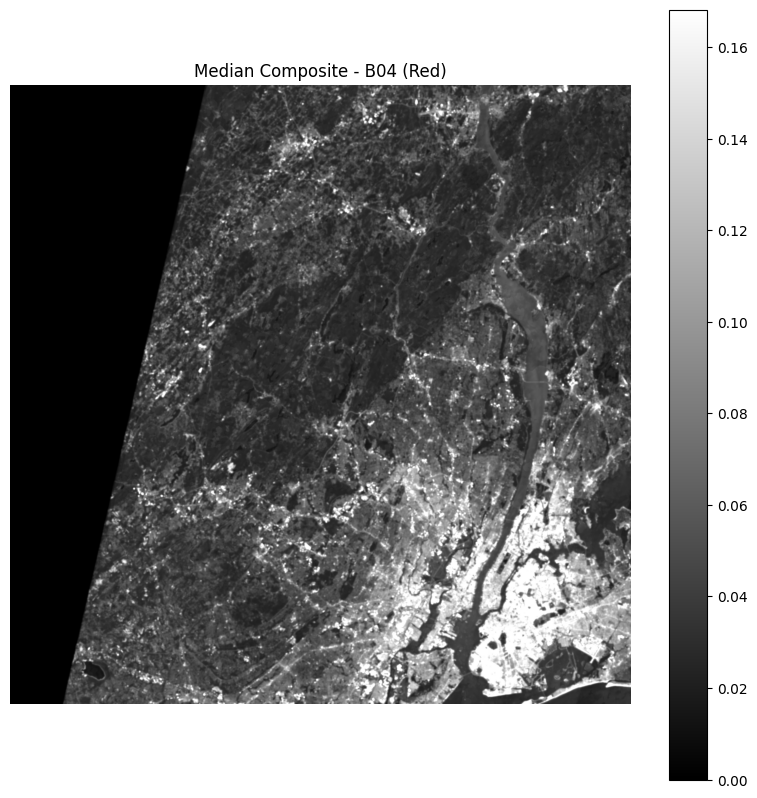

In [ ]:
import os
import glob
import numpy as np
import rasterio
import rioxarray as rxr
import planetary_computer
import pystac_client
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

# Create directories to save outputs
output_dir = "sentinel2_images"
median_output_dir = "median_composites"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(median_output_dir, exist_ok=True)

# Define area of interest (Bounding Box - [min_lon, min_lat, max_lon, max_lat])
bbox=[-73.99445667, 40.75879167, -73.87945833, 40.85949667]
#bbox = [-74, 40.758877, -73.879537, 40.86]

## Define spectral bands (including SCL for cloud masking)
spectral_bands = ["WVP", "B01", "B02", "B03", "B04", "B05", "B06", "B08", "B09", "B11", "B12", "AOT", "SCL"]
#
## Connect to Planetary Computer
#catalog = pystac_client.Client.open(
#    "https://planetarycomputer.microsoft.com/api/stac/v1",
#    modifier=planetary_computer.sign_inplace,
#)
#
## Search for Sentinel-2 images with less than 10% cloud cover
#search_5 = catalog.search(
#    collections=["sentinel-2-l2a"],
#    bbox=bbox,
#    datetime="2021-05-01/2021-08-31",
#    query={"eo:cloud_cover": {"lt": 10}},
#)
#
## Additional image from a specific date with higher cloud tolerance
#search_1 = catalog.search(
#    collections=["sentinel-2-l2a"],
#    bbox=bbox,
#    datetime="2021-07-24",
#    query={"eo:cloud_cover": {"lt": 40}},
#)
#
## Combine all found images
#items = list(search_5.items()) + list(search_1.items())
#print(f"Total images found: {len(items)}")
#
## Download and save each band as GeoTIFF
#for item in tqdm(items, desc="Downloading data"):
#    asset_links = item.assets
#    for band in spectral_bands:
#        if band in asset_links:
#            try:
#                band_data = rxr.open_rasterio(asset_links[band].href, masked=True)
#                band_data = band_data.rio.reproject(
#                    band_data.rio.crs, resolution=(20, 20), resampling=Resampling.bilinear
#                )
#
#                # Replace NaN with -9999 for valid bands
#                if band != "SCL":
#                    band_data = band_data.fillna(-9999)
#
#                output_filename = os.path.join(output_dir, f"{item.id}_{band}.tif")
#                band_data.rio.to_raster(output_filename, compress="lzw")
#
#            except Exception as e:
#                print(f"Error loading {band} from {item.id}: {e}")
#
#print("All bands have been saved as GeoTIFFs.")
#Apply cloud masks before median composite
scl_files = sorted(glob.glob(os.path.join(output_dir, "*_SCL.tif")))
cloud_masks = {}
for scl_file in scl_files:
    try:
        scl = rxr.open_rasterio(scl_file, masked=True)
        scl = scl.fillna(0).astype(np.uint8)
        cloud_mask = (scl != 8) & (scl != 9) & (scl != 10)  # 8/9/10 = Cloud classes
        cloud_masks[os.path.basename(scl_file)] = cloud_mask
    except Exception as e:
        print(f"Error processing SCL {scl_file}: {e}")

# Compute median composite with cloud masking
for band in spectral_bands[:-1]:  # Exclude SCL band
    band_files = sorted(glob.glob(os.path.join(output_dir, f"*_{band}.tif")))

    if not band_files:
        print(f"No images found for band {band}.")
        continue

    print(f"Filtering and computing median composite for {band}...")

    raster_arrays = []
    metadata = None

    for file in band_files:
        try:
            with rasterio.open(file) as src:
                if metadata is None:
                    metadata = src.meta.copy()
                    metadata.update(dtype=rasterio.float32, nodata=-9999, compress="lzw")

                data = src.read(1).astype(np.float32)
                data[data == src.nodata] = np.nan

                # Apply cloud mask
                scl_filename = file.replace(f"_{band}.tif", "_SCL.tif")
                if scl_filename in cloud_masks:
                    mask = cloud_masks[scl_filename]
                    if data.shape == mask.shape:
                        data = np.where(mask, data, np.nan)
                    else:
                        print(f"Dimension mismatch in {file}, skipping.")
                        continue

                # Apply Gaussian blur to reduce noise
                data = gaussian_filter(data, sigma=5)

                raster_arrays.append(data)

        except Exception as e:
            print(f"Error processing {file}: {e}")

    if not raster_arrays:
        continue

    # Remove outliers before computing median
    stacked_array = np.stack(raster_arrays, axis=0)
    lower, upper = np.percentile(stacked_array, [2, 98])
    stacked_array = np.clip(stacked_array, lower, upper)

    # Compute median
    median_mosaic = np.nanmedian(stacked_array, axis=0)
    median_mosaic = np.nan_to_num(median_mosaic, nan=-9999)

    # Apply scaling factor
    median_mosaic = median_mosaic * 0.0001

    output_median_tif = os.path.join(median_output_dir, f"median_{band}.tif")
    with rasterio.open(output_median_tif, "w", **metadata) as dst:
        dst.write(median_mosaic, 1)

print("All median composites have been cleaned from clouds and saved.")

# Visualize the median image for band B04 (Red)
median_image_path = os.path.join(median_output_dir, "median_B04.tif")
median_image = rxr.open_rasterio(median_image_path, masked=True)

plt.figure(figsize=(10, 10))
norm = plt.Normalize(vmin=np.percentile(median_image, 2), vmax=np.percentile(median_image, 98))
plt.imshow(median_image.squeeze(), cmap="gray", norm=norm)
plt.title("Median Composite - B04 (Red)")
plt.axis("off")
plt.colorbar()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Load the original data
file_path = "Training_data_uhi_index_UHI2025-v2.csv"  # Set the correct path
df = pd.read_csv(file_path)

# Keep the original datetime format
df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y %H:%M", errors="coerce")

# Define the number of new samples per original record
num_samples_per_point = 3

# List to store new records
new_samples = []

# Create a KDTree to find the closest timestamp based on location
tree = cKDTree(df[["Longitude", "Latitude"]].values)

# Generate new samples
for _, row in df.iterrows():
    for _ in range(num_samples_per_point):
        # Generate small random shifts in geographic coordinates
        new_longitude = row["Longitude"] + np.random.uniform(-0.0005, 0.0005)
        new_latitude = row["Latitude"] + np.random.uniform(-0.0005, 0.0005)

        # Slight random variation in UHI Index
        new_uhi = row["UHI Index"] + np.random.uniform(-0.001, 0.001)

        # Find the closest original record to assign its timestamp
        dist, idx = tree.query([new_longitude, new_latitude])
        nearest_time = df.iloc[idx]["datetime"]

        # Append to the new samples list
        new_samples.append([new_longitude, new_latitude, nearest_time, new_uhi])

# Create a DataFrame from the new samples
df_new = pd.DataFrame(new_samples, columns=["Longitude", "Latitude", "datetime", "UHI Index"])

# Convert datetime back to the original format before saving
df_new["datetime"] = df_new["datetime"].dt.strftime("%d-%m-%Y %H:%M")
df["datetime"] = df["datetime"].dt.strftime("%d-%m-%Y %H:%M")

# Concatenate original and new data
df_final = pd.concat([df, df_new], ignore_index=True)

# Save the new CSV file without changing the datetime format
output_file = "Augmented_UHI_Data_v2.csv"
df_final.to_csv(output_file, index=False)

print(f"Done! The augmented data was saved to {output_file} with the correct datetime format.")


Done! The augmented data was saved to Augmented_UHI_Data_v2.csv with the correct datetime format.


In [ ]:
def map_satellite_data(csv_path):
    """
    Maps the values of all spectral bands from the median composites to the coordinates from the CSV.
    """
    # Read the CSV file with coordinates
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Transform coordinates from EPSG:4326 to the CRS of the raster images
    transformer = Transformer.from_crs("EPSG:4326", resampled_bands["B04"].rio.crs, always_xy=True)

    # Create a dictionary to store the values of each spectral band
    bands_values = {band: [] for band in spectral_bands}

    # Loop through coordinates and map band values from the raster
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping spectral values"):
        x, y = transformer.transform(lon, lat)  # Convert to raster CRS

        # Extract the value for each band at the given location
        for band in spectral_bands:
            bands_values[band].append(resampled_bands[band].sel(x=x, y=y, method="nearest").values.item())

    # Create a DataFrame with the band values
    bands_df = pd.DataFrame(bands_values)

    return bands_df




def extract_buffer_mean(raster_path, buffer_geom):
    """
    Calculates the mean pixel value within a buffer area around a point.
    """
    with rasterio.open(raster_path) as src:
        buffer_geom = [buffer_geom]
        out_image, out_transform = mask(src, buffer_geom, crop=True)
        data = out_image[0]
        data = data[data > 0]  # Remove NoData (zeros)
        return np.mean(data) if data.size > 0 else np.nan

def combine_two_datasets(dataset1, dataset2):
    """
    Combines two datasets horizontally (column-wise), avoiding duplicate columns.
    """
    # Drop duplicated columns in dataset2
    overlapping_cols = [col for col in dataset2.columns if col in dataset1.columns]
    dataset2 = dataset2.drop(columns=overlapping_cols)

    return pd.concat([dataset1, dataset2], axis=1)


In [ ]:
import os
import pandas as pd
import numpy as np
import rasterio
import rioxarray as rxr
import geopandas as gpd
from pyproj import Transformer
from tqdm import tqdm
from rasterio.mask import mask
from shapely.geometry import Point

# Define directories
median_output_dir = "/content/median_composites"

# List of spectral bands to process
spectral_bands = ["WVP", "B01", "B02", "B03", "B04", "B05", "B06", "B08", "B09", "B11", "B12", "AOT"]

# Load median composites as GeoTIFF files
resampled_bands = {
    band: rxr.open_rasterio(os.path.join(median_output_dir, f"median_{band}.tif")) for band in spectral_bands
}



###################  Training Dataset #####################

print(f"Training Dataset")
# Run the point-level mapping
uhi_csv_path = "/content/Training_data_uhi_index_UHI2025-v2.csv"
# uhi_csv_path = "/content/Augmented_UHI_Data_v2.csv"
ground_df = pd.read_csv(uhi_csv_path)
final_data = map_satellite_data(uhi_csv_path)

print(ground_df.shape)
print(final_data.shape)

# Calculate spectral indices
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])

# Replace infinities with NaN
for index in ["NDVI", "NDBI", "NDWI"]:
    final_data[index] = final_data[index].replace([np.inf, -np.inf], np.nan)

# Combine ground data with spectral bands and indices
uhi_data = combine_two_datasets(ground_df, final_data)

uhi_data = uhi_data.sort_values(by=["Latitude", "Longitude"]).drop_duplicates(
    subset=["Latitude", "Longitude"] + spectral_bands + ["NDVI", "NDBI", "NDWI"],
    keep='last'
).reset_index(drop=True)

# Save the point-level dataset
point_output_csv = "/content/UHI_Spectral_Point_Level.csv"
uhi_data.to_csv(point_output_csv, index=False)
print(f"Saved point-level dataset to: {point_output_csv}")

# Create 150m buffer around each point and extract mean values
uhi_gdf = gpd.GeoDataFrame(
    uhi_data, geometry=gpd.points_from_xy(uhi_data.Longitude, uhi_data.Latitude), crs="EPSG:4326"
)

# Project to UTM zone (e.g., 18N) for buffering
uhi_gdf = uhi_gdf.to_crs(epsg=32618)  # Change EPSG if needed
buffer_distance = 150  # meters
uhi_gdf["geometry"] = uhi_gdf.geometry.buffer(buffer_distance)

# Extract mean values from raster for each buffer
for band in spectral_bands:
    print(f"Processing buffer for {band}...")
    uhi_gdf[f"{band}_mean"] = uhi_gdf.geometry.apply(
        lambda geom: extract_buffer_mean(os.path.join(median_output_dir, f"median_{band}.tif"), geom)
    )

# Reproject back to geographic coordinates
uhi_gdf = uhi_gdf.to_crs(epsg=4326)

# Save buffered dataset
buffer_output_csv = "/content/UHI_Buffered_Median_Values.csv"
uhi_gdf.drop(columns=["geometry"]).to_csv(buffer_output_csv, index=False)
uhi_data=uhi_gdf
print(f"Saved buffered dataset to: {buffer_output_csv}")

print(f"1) Point-level dataset saved to: {point_output_csv}")
print(f"2) Buffered dataset saved to: {buffer_output_csv}")




###################  Validation Dataset #####################


print(f"Validation Dataset")
# Execute mapping of spectral bands for the Validation Dataset
val_csv_path = "/content/Submission_template_UHI2025-v2.csv"
val_df = pd.read_csv(val_csv_path)
final_data = map_satellite_data(val_csv_path)

print(val_df.shape)
print(final_data.shape)

# Calculate spectral indices
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])

# Replace infinite values with NaN
for index in ["NDVI", "NDBI", "NDWI"]:
    final_data[index] = final_data[index].replace([np.inf, -np.inf], np.nan)

# Combine validation data with spectral values and indices
val_spectral_data = combine_two_datasets(val_df, final_data)

# Remove duplicates and sort
val_spectral_data = val_spectral_data.sort_values(by=["Latitude", "Longitude"]).drop_duplicates(
    subset=["Latitude", "Longitude"] + spectral_bands + ["NDVI", "NDBI", "NDWI"],
    keep='last'
).reset_index(drop=True)

# Save the point-level dataset
val_point_output_csv = "/content/Validation_Spectral_Point_Level.csv"
val_spectral_data.to_csv(val_point_output_csv, index=False)
print(f"Saved: {val_point_output_csv}")

# Create 150m buffer around validation points
val_gdf = gpd.GeoDataFrame(
    val_spectral_data, geometry=gpd.points_from_xy(val_spectral_data.Longitude, val_spectral_data.Latitude), crs="EPSG:4326"
)

# Reproject to UTM zone for buffering
val_gdf = val_gdf.to_crs(epsg=32618)  # Change EPSG if area is outside UTM zone 18N
buffer_distance = 150  # in meters
val_gdf["geometry"] = val_gdf.geometry.buffer(buffer_distance)

# Extract mean values from each median band within buffer
for band in spectral_bands:
    print(f"Processing buffer for {band}...")
    val_gdf[f"{band}_mean"] = val_gdf.geometry.apply(
        lambda geom: extract_buffer_mean(os.path.join(median_output_dir, f"median_{band}.tif"), geom)
    )

# Reproject back to geographic coordinates
val_gdf = val_gdf.to_crs(epsg=4326)

# Save buffered dataset
val_buffer_output_csv = "/content/Validation_Buffered_Median_Values.csv"
val_gdf.drop(columns=["geometry"]).to_csv(val_buffer_output_csv, index=False)
val_data=val_gdf
print(f"Saved: {val_buffer_output_csv}")

# Final output
print(f"1. Point-level data: {val_point_output_csv}")
print(f"2. Buffered data (150m): {val_buffer_output_csv}")


Training Dataset


Mapping spectral values: 100%|██████████| 11229/11229 [03:15<00:00, 57.50it/s]


(11229, 4)
(11229, 12)
Saved point-level dataset to: /content/UHI_Spectral_Point_Level.csv
Processing buffer for WVP...
Processing buffer for B01...
Processing buffer for B02...
Processing buffer for B03...
Processing buffer for B04...
Processing buffer for B05...
Processing buffer for B06...
Processing buffer for B08...
Processing buffer for B09...
Processing buffer for B11...
Processing buffer for B12...
Processing buffer for AOT...
Saved buffered dataset to: /content/UHI_Buffered_Median_Values.csv
1) Point-level dataset saved to: /content/UHI_Spectral_Point_Level.csv
2) Buffered dataset saved to: /content/UHI_Buffered_Median_Values.csv
Validation Dataset


Mapping spectral values: 100%|██████████| 1040/1040 [00:17<00:00, 59.87it/s]


(1040, 3)
(1040, 12)
Saved: /content/Validation_Spectral_Point_Level.csv
Processing buffer for WVP...
Processing buffer for B01...
Processing buffer for B02...
Processing buffer for B03...
Processing buffer for B04...
Processing buffer for B05...
Processing buffer for B06...
Processing buffer for B08...
Processing buffer for B09...
Processing buffer for B11...
Processing buffer for B12...
Processing buffer for AOT...
Saved: /content/Validation_Buffered_Median_Values.csv
1. Point-level data: /content/Validation_Spectral_Point_Level.csv
2. Buffered data (150m): /content/Validation_Buffered_Median_Values.csv


#2o Dataset

In [ ]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet, RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load
from pystac_client import Client

# Open STAC client for Planetary Computer
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search for Landsat-8 data using the bounding box
search = stac.search(
    collections=["landsat-c2-l2"],
    #bbox = [-74, 40.758877, -73.879537, 40.86]
    bbox=[-73.99445667, 40.75879167, -73.87953667, 40.85949667],  # Area of interest
    datetime="2021-07-01/2021-08-31",  # Date range
    query={
        "eo:cloud_cover": {"lt": 40},  # Filter by cloud cover < 40%
        "platform": {"in": ["landsat-8"]}  # Only Landsat-8
    }
)

# Retrieve items
items = list(search.get_items())
print(f"Found {len(items)} images.")

Found 3 images.


In [ ]:
for i, item in enumerate(items):
    print(f"Item {i + 1} - Available bands: {item.assets.keys()}")

signed_items = [planetary_computer.sign(item).to_dict() for item in items]
# Define the pixel resolution for the final product
# Define the scale according to the selected CRS (degrees per pixel for EPSG:4326)
resolution = 30  # meters per pixel
scale = resolution / 111320.0  # degrees per pixel (approximate)

# Area of interest (bounding box)
bounds = [-74, 40.758877, -73.879537, 40.86]

# List of bands to include from each group
bands_to_include_1 = ['red', 'green', 'blue', 'coastal', 'nir08', 'atran', 'swir16', 'swir22']
bands_to_include_2 = ['lwir11']
bands_to_include_3 = ['emis', 'cdist', 'emsd', 'trad', 'drad', 'urad']

# Load data for the first set of bands
data1 = stac_load(
    items,
    bands=bands_to_include_1,
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="float32",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

# Load data for the second set of bands
data2 = stac_load(
    items,
    bands=bands_to_include_2,
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="float32",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

# Load data for the third set of bands
data5 = stac_load(
    items,
    bands=bands_to_include_3,
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="float32",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

# Display included bands in each dataset
print("Dataset 1 contains the bands:", data1.data_vars.keys())
print("Dataset 2 contains the bands:", data2.data_vars.keys())
print("Dataset 5 contains the bands:", data5.data_vars.keys())


Item 1 - Available bands: dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])
Item 2 - Available bands: dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])
Item 3 - Available bands: dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])
Dataset 1 contains the bands: KeysView(Data variables:
    red      (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376

In [ ]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data1)
display(data2)
display(data5)

<xarray.Dataset> Size: 16MB
Dimensions:      (latitude: 376, longitude: 448, time: 3)
Coordinates:
  * latitude     (latitude) float64 3kB 40.86 40.86 40.86 ... 40.76 40.76 40.76
  * longitude    (longitude) float64 4kB -74.0 -74.0 -74.0 ... -73.88 -73.88
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2021-07-18T15:33:37.770322 ... 202...
Data variables:
    red          (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    green        (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    blue         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    coastal      (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    nir08        (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    atran        (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    swir16       (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    swir22       (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>

<xarray.Dataset> Size: 2MB
Dimensions:      (latitude: 376, longitude: 448, time: 3)
Coordinates:
  * latitude     (latitude) float64 3kB 40.86 40.86 40.86 ... 40.76 40.76 40.76
  * longitude    (longitude) float64 4kB -74.0 -74.0 -74.0 ... -73.88 -73.88
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2021-07-18T15:33:37.770322 ... 202...
Data variables:
    lwir11       (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>

<xarray.Dataset> Size: 12MB
Dimensions:      (latitude: 376, longitude: 448, time: 3)
Coordinates:
  * latitude     (latitude) float64 3kB 40.86 40.86 40.86 ... 40.76 40.76 40.76
  * longitude    (longitude) float64 4kB -74.0 -74.0 -74.0 ... -73.88 -73.88
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2021-07-18T15:33:37.770322 ... 202...
Data variables:
    emis         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    cdist        (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    emsd         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    trad         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    drad         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>
    urad         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 376, 448), meta=np.ndarray>

In [ ]:
# Persist the data in memory for faster operations
data1 = data1.persist()
data2 = data2.persist()
data5 = data5.persist()

In [ ]:
# Scale Factors for the RGB and NIR bands
scale1 = 0.0000275
offset1 = -0.2
data1 = data1.astype(float) * scale1 + offset1

In [ ]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

In [ ]:
import xarray as xr
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select only the numeric variables from the Xarray dataset
numeric_vars = list(data5.data_vars.keys())  # All available bands

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Convert data into a large 2D array for scaling (flattened)
data5_flat = np.array([data5[var].values.flatten() for var in numeric_vars]).T  # (Pixels, Features)

# Apply Min-Max Scaling
data5_scaled_flat = scaler.fit_transform(data5_flat)

# Reshape the scaled data back into the original Xarray structure
for i, var in enumerate(numeric_vars):
    data5[var].values = data5_scaled_flat[:, i].reshape(data5[var].shape)

# Display the dataset after normalization
print(data5)


<xarray.Dataset> Size: 12MB
Dimensions:      (latitude: 376, longitude: 448, time: 3)
Coordinates:
  * latitude     (latitude) float64 3kB 40.86 40.86 40.86 ... 40.76 40.76 40.76
  * longitude    (longitude) float64 4kB -74.0 -74.0 -74.0 ... -73.88 -73.88
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2021-07-18T15:33:37.770322 ... 202...
Data variables:
    emis         (time, latitude, longitude) float32 2MB 0.9955 ... 0.9846
    cdist        (time, latitude, longitude) float32 2MB 0.9574 0.9577 ... 1.0
    emsd         (time, latitude, longitude) float32 2MB 0.9711 ... 0.9671
    trad         (time, latitude, longitude) float32 2MB 0.8457 ... 0.9105
    drad         (time, latitude, longitude) float32 2MB 0.9997 ... 0.9771
    urad         (time, latitude, longitude) float32 2MB 0.9991 ... 0.9425


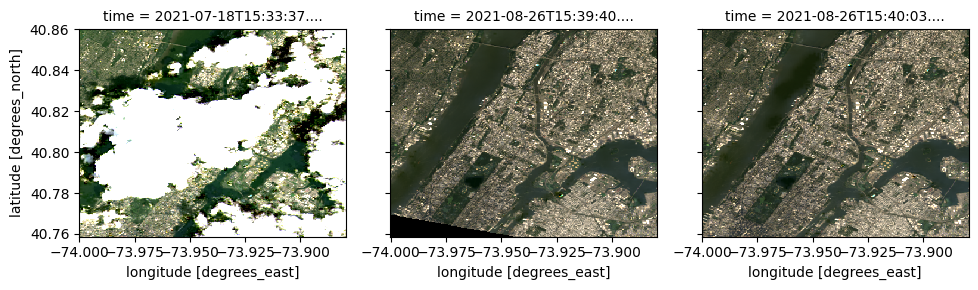

In [ ]:
#plot_data = data1[["red","green","blue","coastal","nir08", "atran"]].to_array()
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

In [ ]:
# Pick one of the scenes above (numbering starts with 0)
scene =2

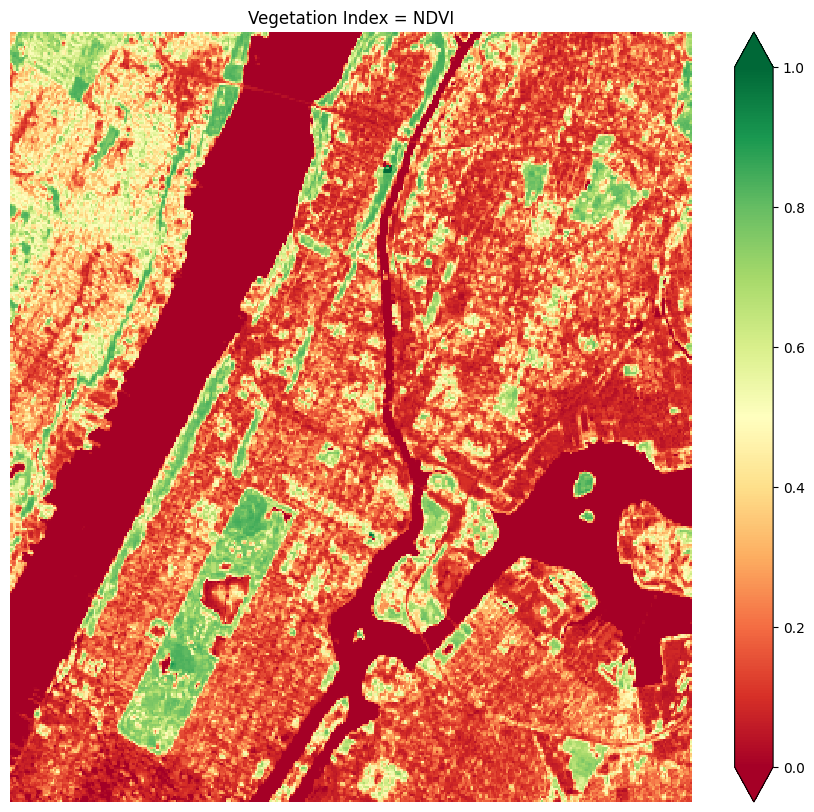

In [ ]:
# Calculate NDVI for the median mosaic
ndvi_data = (data1.isel(time=scene).nir08-data1.isel(time=scene).red)/(data1.isel(time=scene).nir08+data1.isel(time=scene).red)
fig, ax = plt.subplots(figsize=(11,10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

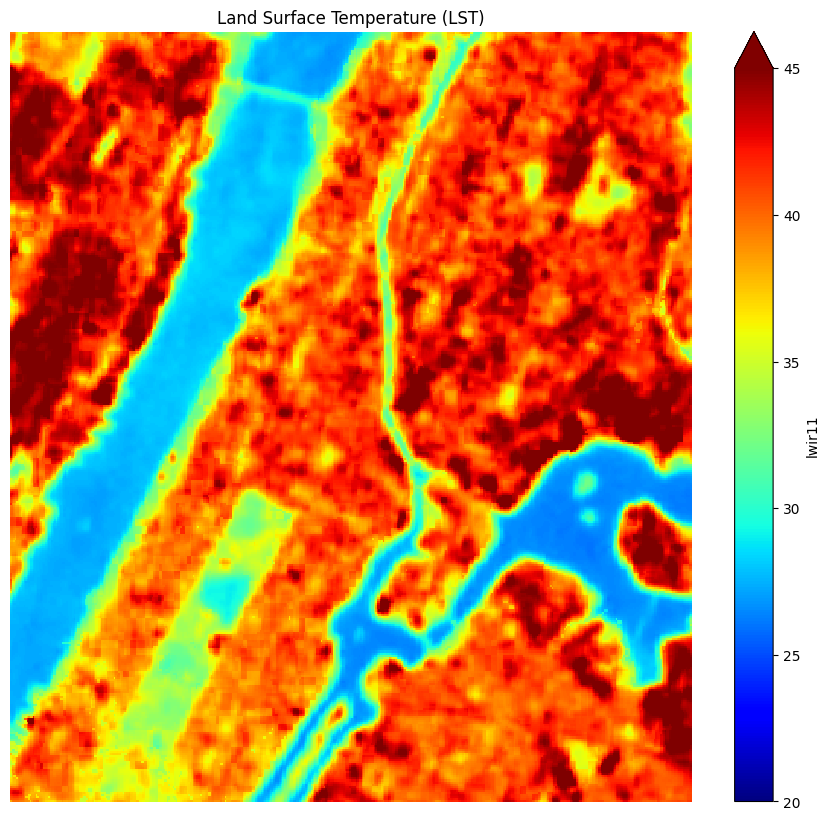

In [ ]:
fig, ax = plt.subplots(figsize=(11,10))
data2.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

In [ ]:
import rasterio

# Select a single time snapshot from data2
data3 = data2.isel(time=scene)

# Define the output filename
filename = "Landsat_LST.tiff"

# Get the dimensions of the raster
height = data3.dims["latitude"]
width = data3.dims["longitude"]

# Define the coordinate reference system (CRS) and transform
gt = rasterio.transform.from_bounds(-73.99316333, 40.75887667, -73.87953667, 40.85924333, width, height)
data3.rio.write_crs("EPSG:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True)

# Save the thermal band to GeoTIFF
with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                   crs='EPSG:4326', transform=gt, count=1, compress='lzw', dtype='float64') as dst:
    dst.write(data3.lwir11, 1)  # Band 1 - Longwave Infrared (Thermal)

# List the saved TIFF files
!ls *.tiff


Landsat_LST.tiff


In [ ]:
# Select a single time snapshot from data1
data4 = data1.isel(time=scene)

# Define the output filename
filename = "Landsat_Optical_Bands.tiff"

# Get the dimensions of the raster
height = data4.dims["latitude"]
width = data4.dims["longitude"]

# Define the coordinate reference system (CRS) and transform
gt = rasterio.transform.from_bounds(-73.99316333, 40.75887667, -73.87953667, 40.85924333, width, height)
data4.rio.write_crs("epsg:4326", inplace=True)
data4.rio.write_transform(transform=gt, inplace=True)

# Save all optical bands to GeoTIFF
with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                   crs='epsg:4326', transform=gt, count=8, compress='lzw', dtype='float64') as dst:
    dst.write(data4.red, 1)     # Band 1 - Red
    dst.write(data4.green, 2)   # Band 2 - Green
    dst.write(data4.blue, 3)    # Band 3 - Blue
    dst.write(data4.coastal, 4) # Band 4 - Coastal
    dst.write(data4.nir08, 5)   # Band 5 - Near Infrared (NIR)
    dst.write(data4.atran, 6)   # Band 6 - Atmospheric Transmission
    dst.write(data4.swir16, 7)  # Band 7 - SWIR 1
    dst.write(data4.swir22, 8)  # Band 8 - SWIR 2

# List the saved TIFF files
!ls *.tiff


Landsat_LST.tiff  Landsat_Optical_Bands.tiff


In [ ]:
# Select a single time snapshot from data5
data6 = data5.isel(time=scene)

# Define the output filename
filename = "Landsat_SWIR_Emissivity_Bands.tiff"

# Get the dimensions of the raster
height = data6.dims["latitude"]
width = data6.dims["longitude"]

# Define the coordinate reference system (CRS) and transform
gt = rasterio.transform.from_bounds(-73.99316333, 40.75887667, -73.87953667, 40.85924333, width, height)
data6.rio.write_crs("epsg:4326", inplace=True)
data6.rio.write_transform(transform=gt, inplace=True)

# Save all SWIR and emissivity-related bands to GeoTIFF
with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                   crs='epsg:4326', transform=gt, count=6, compress='lzw', dtype='float64') as dst:
    dst.write(data6.emis, 1)    # Band 1 - Emissivity
    dst.write(data6.cdist, 2)   # Band 2 - Cloud Distance
    dst.write(data6.emsd, 3)    # Band 3 - Emissivity Std. Dev.
    dst.write(data6.trad, 4)    # Band 4 - Thermal Radiance
    dst.write(data6.drad, 5)    # Band 5 - Downwelling Radiance
    dst.write(data6.urad, 6)    # Band 6 - Upwelling Radiance

# List the saved TIFF files
!ls *.tiff


Landsat_LST.tiff	    Landsat_SWIR_Emissivity_Bands.tiff
Landsat_Optical_Bands.tiff


Average Temperature: 38.14 °C
Minimum Temperature: 25.96 °C
Maximum Temperature: 58.94 °C


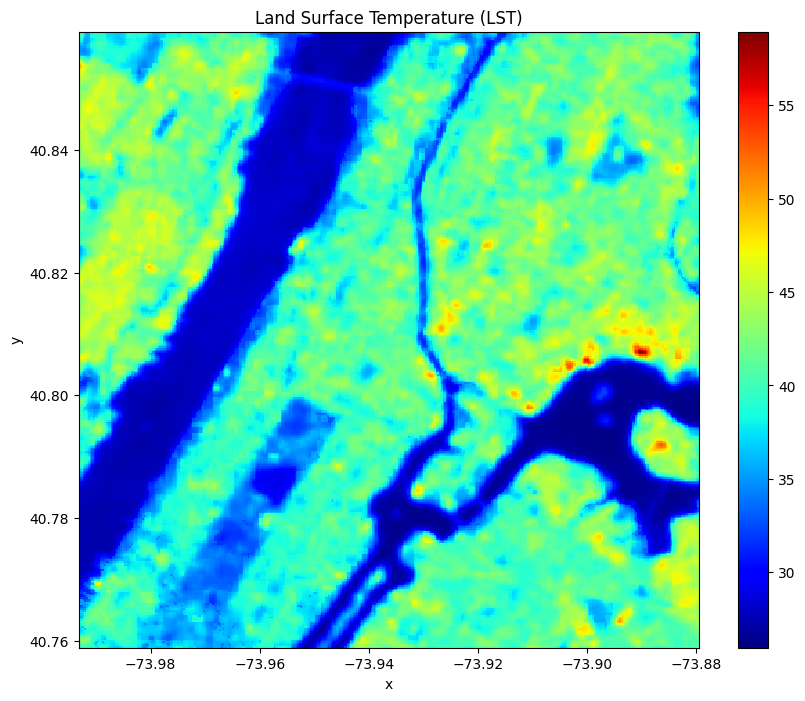

In [ ]:
import rioxarray as rxr
import matplotlib.pyplot as plt

# Load the GeoTIFF file
lst_data = rxr.open_rasterio("Landsat_LST.tiff", masked=True)

# Calculate basic temperature statistics
print(f"Average Temperature: {lst_data[0].mean().item():.2f} °C")
print(f"Minimum Temperature: {lst_data[0].min().item():.2f} °C")
print(f"Maximum Temperature: {lst_data[0].max().item():.2f} °C")

# Visualize the temperature using the "jet" colormap
fig, ax = plt.subplots(figsize=(10, 8))
lst_data.sel(band=1).plot(cmap="jet", ax=ax)
plt.title("Land Surface Temperature (LST)")
plt.show()


In [ ]:
import os
print(os.listdir("."))

['.config', 'Validation_Buffered_Median_Values.csv', 'median_composites', 'Landsat_SWIR_Emissivity_Bands.tiff', 'NY_Mesonet_Weather.xlsx', 'Landsat_LST.tiff', 'UHI_Spectral_Point_Level.csv', 'manhattan_bronx_buildings.geojson', 'UHI_Buffered_Median_Values.csv', 'Training_data_uhi_index_UHI2025-v2.csv', 'sentinel2_images', 'Landsat_Optical_Bands.tiff', 'Validation_Spectral_Point_Level.csv', 'cache', 'Augmented_UHI_Data_v2.csv', 'Submission_template_UHI2025-v2.csv', 'Building_Footprint.kml', 'sample_data']


In [ ]:
import rioxarray as rxr
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the GeoTIFF file with all thermal bands
lst_data = rxr.open_rasterio("Landsat_LST.tiff", masked=True)

# Convert bands into an Xarray Dataset (make sure it's a 3D multi-band dataset)
if len(lst_data.shape) == 3:  # (bands, y, x)
    bands, height, width = lst_data.shape
else:
    raise ValueError("The file does not have the correct dimensions (expected 3D with bands)")

# Extract coordinates
latitudes = lst_data.y.values
longitudes = lst_data.x.values

# Initialize a list to store the data
lst_values = []

# Extract pixel-level values (lat, lon) for all bands
for i, lat in tqdm(enumerate(latitudes), total=len(latitudes), desc="Processing LST Data"):
    for j, lon in enumerate(longitudes):
        pixel_values = lst_data[:, i, j].values  # Get values for all bands at the pixel
        lst_values.append({
            "Latitude": lat,
            "Longitude": lon,
            "LST": pixel_values[0],  # Band 1 - LST
            # "Trad": pixel_values[1],  # Band 2 - Thermal Radiance
            # "Drad": pixel_values[2],  # Band 3 - Downwelling Radiance
            # "Urad": pixel_values[3]   # Band 4 - Upwelling Radiance
        })

# Convert the list to a Pandas DataFrame
lst_df = pd.DataFrame(lst_values)

# Show the first few rows
print(lst_df.head())


Processing LST Data: 100%|██████████| 376/376 [01:41<00:00,  3.72it/s]


   Latitude  Longitude        LST
0  40.85911 -73.993037  39.689371
1  40.85911 -73.992783  39.439855
2  40.85911 -73.992529  39.439855
3  40.85911 -73.992276  38.578514
4  40.85911 -73.992022  36.920774


In [ ]:
import pandas as pd
from tqdm import tqdm
import rioxarray as rxr

# Load the GeoTIFF file
data1 = rxr.open_rasterio("Landsat_Optical_Bands.tiff", masked=True)

# Ensure the CRS is EPSG:4326
data1 = data1.rio.reproject("EPSG:4326")

latitudes = data1["y"].values
longitudes = data1["x"].values

data1_values = []

bands_count, height, width = data1.shape  # (bands, y, x)

for i in tqdm(range(height), desc="Processing Optical Bands Data"):
    lat = latitudes[i]
    for j in range(width):
        lon = longitudes[j]
        values = data1[:, i, j].values
        data1_values.append({
            "Latitude": lat,
            "Longitude": lon,
            "Red": values[0],
            "Green": values[1],
            "Blue": values[2],
            "Coastal": values[3],
            "NIR08": values[4],
            "Atran": values[5],
            "SWIR16": values[6],
            "SWIR22": values[7]
        })

data1_df = pd.DataFrame(data1_values)
data1_df.to_csv("Optical_Bands_Data.csv", index=False)
print(data1_df.head())


Processing Optical Bands Data: 100%|██████████| 376/376 [00:32<00:00, 11.60it/s]


   Latitude  Longitude       Red     Green      Blue   Coastal     NIR08  \
0  40.85911 -73.993037  0.115893  0.095625  0.077145  0.073927  0.213243   
1  40.85911 -73.992783  0.119632  0.097413  0.080087  0.074533  0.216213   
2  40.85911 -73.992529  0.119632  0.097413  0.080087  0.074533  0.216213   
3  40.85911 -73.992276  0.131265  0.106982  0.083965  0.077035  0.252430   
4  40.85911 -73.992022  0.087512  0.082728  0.059600  0.057372  0.266757   

     Atran    SWIR16    SWIR22  
0 -0.03104  0.286090  0.214618  
1 -0.03104  0.289610  0.219622  
2 -0.03104  0.289610  0.219622  
3 -0.03104  0.346920  0.242255  
4 -0.03104  0.272037  0.165090  


In [ ]:
import rioxarray as rxr
import pandas as pd
from tqdm import tqdm

# Load the GeoTIFF file
data2 = rxr.open_rasterio("Landsat_SWIR_Emissivity_Bands.tiff", masked=True)

# Ensure the CRS is EPSG:4326
data2 = data2.rio.reproject("EPSG:4326")

latitudes = data2.y.values
longitudes = data2.x.values

data2_values = []

bands_count, height, width = data2.shape  # (bands, y, x)

for i in tqdm(range(height), desc="Processing SWIR & Emissivity Bands Data"):
    lat = latitudes[i]
    for j in range(width):
        lon = longitudes[j]
        values = data2[:, i, j].values
        data2_values.append({
            "Latitude": lat,
            "Longitude": lon,
            "Emis": values[0],
            "CDist": values[1],
            "EMSD": values[2],
            "Trad": values[3],
            "Drad": values[4],
            "Urad": values[5]
        })

data2_df = pd.DataFrame(data2_values)
data2_df.to_csv("SWIR_Emissivity_Bands_Data.csv", index=False)

print(data2_df.head())


Processing SWIR & Emissivity Bands Data: 100%|██████████| 376/376 [00:40<00:00,  9.33it/s]


   Latitude  Longitude      Emis     CDist      EMSD      Trad      Drad  \
0  40.85911 -73.993037  0.991509  0.975105  0.971135  0.906220  0.979122   
1  40.85911 -73.992783  0.991459  0.975297  0.971135  0.905143  0.979122   
2  40.85911 -73.992529  0.991459  0.975297  0.971135  0.905143  0.979122   
3  40.85911 -73.992276  0.991810  0.975393  0.971135  0.901684  0.979122   
4  40.85911 -73.992022  0.994021  0.975488  0.967875  0.895935  0.979122   

       Urad  
0  0.946755  
1  0.946755  
2  0.946755  
3  0.946755  
4  0.946755  


In [ ]:
# Ensure the dataframes have the correct columns for merging
common_cols = ["Latitude", "Longitude"]

# Merge the three DataFrames based on Latitude & Longitude
merged_df = pd.merge(lst_df, data1_df, on=common_cols, how="inner")
merged_df = pd.merge(merged_df, data2_df, on=common_cols, how="inner")

# Update lst_df with the merged DataFrame
lst_df = merged_df

# Display the first few rows to verify the merge
print(lst_df.head())


   Latitude  Longitude        LST       Red     Green      Blue   Coastal  \
0  40.85911 -73.993037  39.689371  0.115893  0.095625  0.077145  0.073927   
1  40.85911 -73.992783  39.439855  0.119632  0.097413  0.080087  0.074533   
2  40.85911 -73.992529  39.439855  0.119632  0.097413  0.080087  0.074533   
3  40.85911 -73.992276  38.578514  0.131265  0.106982  0.083965  0.077035   
4  40.85911 -73.992022  36.920774  0.087512  0.082728  0.059600  0.057372   

      NIR08    Atran    SWIR16    SWIR22      Emis     CDist      EMSD  \
0  0.213243 -0.03104  0.286090  0.214618  0.991509  0.975105  0.971135   
1  0.216213 -0.03104  0.289610  0.219622  0.991459  0.975297  0.971135   
2  0.216213 -0.03104  0.289610  0.219622  0.991459  0.975297  0.971135   
3  0.252430 -0.03104  0.346920  0.242255  0.991810  0.975393  0.971135   
4  0.266757 -0.03104  0.272037  0.165090  0.994021  0.975488  0.967875   

       Trad      Drad      Urad  
0  0.906220  0.979122  0.946755  
1  0.905143  0.979122  0

# 3o Dataset

In [ ]:
import geopandas as gpd

# Path to the KML file
file_path = "/content/Building_Footprint.kml"

# Read the KML file as a GeoDataFrame
gdf = gpd.read_file(file_path, driver='KML')

# Display the full structure of the GeoDataFrame
print(gdf)


     Name Description                                           geometry
0                      MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...
1                      MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...
2                      MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...
3                      MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...
4                      MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...
...   ...         ...                                                ...
9431                   MULTIPOLYGON (((-73.95267 40.77923, -73.95254 ...
9432                   MULTIPOLYGON (((-73.94964 40.77613, -73.94931 ...
9433                   MULTIPOLYGON (((-73.9521 40.7688, -73.95174 40...
9434                   MULTIPOLYGON (((-73.9523 40.75904, -73.95246 4...
9435                   MULTIPOLYGON (((-73.95579 40.76314, -73.95602 ...

[9436 rows x 3 columns]


In [ ]:
from shapely.geometry import MultiPolygon

# Extract coordinates from each row
for index, row in gdf.iterrows():
    print(f"Geometry {index}:")
    geom = row['geometry']

    # Check if the geometry is a MultiPolygon
    if isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:  # Access each Polygon in the MultiPolygon
            print(list(polygon.exterior.coords))  # Coordinates of the outer ring
    else:
        print(list(geom.exterior.coords))  # Coordinates if it's a simple Polygon


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
[(-73.968209, 40.802508), (-73.969436, 40.802962), (-73.969433, 40.802992), (-73.969386, 40.80302), (-73.969327, 40.803113), (-73.96905, 40.803013), (-73.969038, 40.803001), (-73.968974, 40.80304), (-73.96887, 40.803032), (-73.968842, 40.803076), (-73.968903, 40.803134), (-73.968788, 40.803313), (-73.968765, 40.803327), (-73.968206, 40.803124), (-73.968328, 40.80293), (-73.968621, 40.802952), (-73.968634, 40.802944), (-73.968594, 40.802906), (-73.968389, 40.802829), (-73.968294, 40.802887), (-73.968262, 40.802938), (-73.968208, 40.802934), (-73.968202, 40.802974), (-73.968248, 40.802991), (-73.96818, 40.803099), (-73.967899, 40.802997), (-73.968209, 40.802508)]
Geometry 6938:
[(-73.973767, 40.793713), (-73.973852, 40.793579), (-73.973898, 40.793596), (-73.97403, 40.793388), (-73.974126, 40.793423), (-73.974149, 40.793386), (-73.974031, 40.793343), (-73.974113, 40.793215), (-73.974402, 40.79332), (-73.974081, 40.793827), (-73.973767

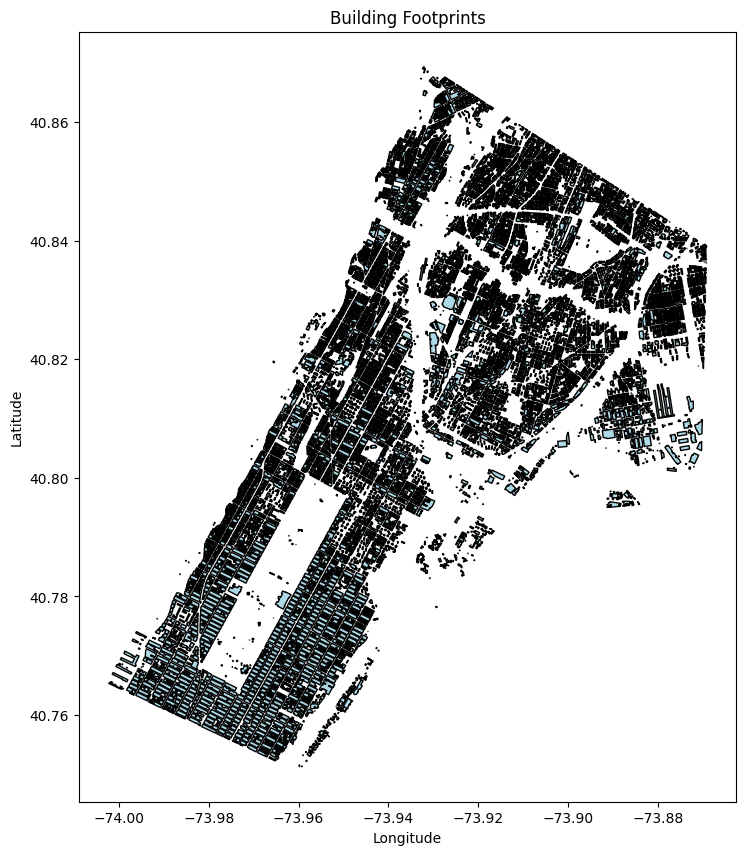

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Visualize the spatial data
gdf.plot(color="lightblue", edgecolor="black", figsize=(10, 10))
plt.title("Building Footprints")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
# Convert from EPSG:4326 to EPSG:32618
footprints_gdf = gdf.copy()

# Calculate the area in square meters (uncomment after setting appropriate projection)
# footprints_gdf['Area'] = footprints_gdf['geometry'].area

# Display the geometries and their areas (uncomment if 'Area' column is calculated)
# print(footprints_gdf[['geometry', 'Area']])

# Preview the first few rows
print(footprints_gdf.head())

# Print the current coordinate reference system
print(footprints_gdf.crs)

# Check if there are any empty geometries
if footprints_gdf.is_empty.any():
    print("There are empty geometries in footprints_gdf!")


  Name Description                                           geometry
0                   MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...
1                   MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...
2                   MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...
3                   MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...
4                   MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...
EPSG:4326


In [ ]:
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree

# Convert to UTM (EPSG:32618) for accurate area calculation
footprints_gdf_utm = footprints_gdf.to_crs("EPSG:32618")

# Calculate area in square meters
footprints_gdf_utm["Area"] = footprints_gdf_utm.geometry.area

# Convert back to EPSG:4326 for compatibility with other data
footprints_gdf = footprints_gdf_utm.to_crs("EPSG:4326")

# Calculate centroid (center of mass)
footprints_gdf["Centroid"] = footprints_gdf["geometry"].centroid

# Calculate perimeter (in degrees, not meters)
footprints_gdf["Perimeter"] = footprints_gdf["geometry"].length

# Calculate compactness index
footprints_gdf["Compactness"] = (4 * np.pi * footprints_gdf["Area"]) / (footprints_gdf["Perimeter"] ** 2)

# Calculate bounding box and aspect ratio
footprints_gdf["Bounding_Box"] = footprints_gdf["geometry"].envelope
footprints_gdf["Bounding_Width"] = footprints_gdf["Bounding_Box"].apply(lambda x: x.bounds[2] - x.bounds[0])
footprints_gdf["Bounding_Height"] = footprints_gdf["Bounding_Box"].apply(lambda x: x.bounds[3] - x.bounds[1])
footprints_gdf["Aspect_Ratio"] = footprints_gdf["Bounding_Width"] / footprints_gdf["Bounding_Height"]

# Calculate distance to nearest building (in meters)
building_coords = np.array([list(geom.centroid.coords)[0] for geom in footprints_gdf["geometry"]])
tree = cKDTree(building_coords)
distances, indices = tree.query(building_coords, k=2)  # k=2 because the first one is itself
footprints_gdf["Distance_to_Nearest_Building"] = distances[:, 1] * 111320  # Convert degrees to meters

# Calculate circularity
footprints_gdf["Circularity"] = (4 * np.pi * footprints_gdf["Area"]) / (footprints_gdf["Perimeter"] ** 2)

# Calculate elongation
footprints_gdf["Elongation"] = footprints_gdf["Aspect_Ratio"].apply(lambda x: max(x, 1 / x))

# Calculate rectangularity
footprints_gdf["Bounding_Box_Area"] = footprints_gdf["Bounding_Box"].area
footprints_gdf["Rectangularity"] = footprints_gdf["Area"] / footprints_gdf["Bounding_Box_Area"]

# Calculate solidity
footprints_gdf["Convex_Hull_Area"] = footprints_gdf["geometry"].convex_hull.area
footprints_gdf["Solidity"] = footprints_gdf["Area"] / footprints_gdf["Convex_Hull_Area"]

# Calculate fractal dimension
footprints_gdf["Fractal_Dimension"] = (2 * np.log(footprints_gdf["Perimeter"])) / np.log(footprints_gdf["Area"])

# Calculate compactness ratio
footprints_gdf["Compactness_Ratio"] = footprints_gdf["Area"] / np.sqrt(footprints_gdf["Perimeter"])

# Remove temporary columns
footprints_gdf.drop(columns=["Bounding_Box", "Bounding_Width", "Bounding_Height", "Bounding_Box_Area", "Convex_Hull_Area"], inplace=True)

# Display results
print(footprints_gdf[[
    'geometry', 'Area', "Centroid", "Perimeter", "Compactness",
    "Aspect_Ratio", "Circularity", "Elongation", "Rectangularity",
    "Solidity", "Fractal_Dimension", "Compactness_Ratio"
]])


                                               geometry         Area  \
0     MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...   619.739128   
1     MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...    95.264377   
2     MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...   141.262523   
3     MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...    79.661011   
4     MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...   216.099170   
...                                                 ...          ...   
9431  MULTIPOLYGON (((-73.95267 40.77923, -73.95254 ...  2487.752472   
9432  MULTIPOLYGON (((-73.94964 40.77613, -73.94931 ...  9055.028398   
9433  MULTIPOLYGON (((-73.9521 40.7688, -73.95174 40...  9523.114836   
9434  MULTIPOLYGON (((-73.9523 40.75904, -73.95246 4...  1545.474820   
9435  MULTIPOLYGON (((-73.95579 40.76314, -73.95602 ...   419.179472   

                        Centroid  Perimeter   Compactness  Aspect_Ratio  \
0      POINT (-73.91927 40.8481)   0.001288  4.695361e+09   

In [ ]:
from scipy.spatial import cKDTree

# Convert to UTM (EPSG:32618) for accurate area calculation
footprints_gdf_utm = footprints_gdf.to_crs("EPSG:32618")

# Calculate area in square meters
footprints_gdf_utm["Area"] = footprints_gdf_utm.geometry.area

# Convert back to EPSG:4326 for compatibility with other datasets
footprints_gdf = footprints_gdf_utm.to_crs("EPSG:4326")

# Calculate centroid
footprints_gdf["Centroid"] = footprints_gdf["geometry"].centroid

# Calculate perimeter (in degrees, not meters)
footprints_gdf["Perimeter"] = footprints_gdf["geometry"].length

# Calculate compactness index
footprints_gdf["Compactness"] = (4 * np.pi * footprints_gdf["Area"]) / (footprints_gdf["Perimeter"] ** 2)

# Calculate aspect ratio using the bounding box
footprints_gdf["Bounding_Box"] = footprints_gdf["geometry"].envelope
footprints_gdf["Bounding_Width"] = footprints_gdf["Bounding_Box"].apply(lambda x: x.bounds[2] - x.bounds[0])
footprints_gdf["Bounding_Height"] = footprints_gdf["Bounding_Box"].apply(lambda x: x.bounds[3] - x.bounds[1])
footprints_gdf["Aspect_Ratio"] = footprints_gdf["Bounding_Width"] / footprints_gdf["Bounding_Height"]

# Calculate distance to the nearest building (in meters)
building_coords = np.array([list(geom.centroid.coords)[0] for geom in footprints_gdf["geometry"]])
tree = cKDTree(building_coords)
distances, indices = tree.query(building_coords, k=2)  # k=2 because the first match is the point itself
footprints_gdf["Distance_to_Nearest_Building"] = distances[:, 1] * 111320  # Convert degrees to meters

# Remove temporary columns
footprints_gdf.drop(columns=["Bounding_Box", "Bounding_Width", "Bounding_Height"], inplace=True)

# Print selected columns
print(footprints_gdf[['geometry', 'Area', "Centroid", "Perimeter", "Compactness", "Aspect_Ratio"]])


                                               geometry         Area  \
0     MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...   619.739128   
1     MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...    95.264377   
2     MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...   141.262523   
3     MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...    79.661011   
4     MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...   216.099170   
...                                                 ...          ...   
9431  MULTIPOLYGON (((-73.95267 40.77923, -73.95254 ...  2487.752472   
9432  MULTIPOLYGON (((-73.94964 40.77613, -73.94931 ...  9055.028399   
9433  MULTIPOLYGON (((-73.9521 40.7688, -73.95174 40...  9523.114836   
9434  MULTIPOLYGON (((-73.9523 40.75904, -73.95246 4...  1545.474820   
9435  MULTIPOLYGON (((-73.95579 40.76314, -73.95602 ...   419.179472   

                        Centroid  Perimeter   Compactness  Aspect_Ratio  
0      POINT (-73.91927 40.8481)   0.001288  4.695361e+09    

# 4o Dataset

In [ ]:
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np
import geopandas as gpd

# Convert UHI data to a GeoDataFrame
uhi_gdf = gpd.GeoDataFrame(
    uhi_data,
    geometry=gpd.points_from_xy(uhi_data["Longitude"], uhi_data["Latitude"]),
    crs="EPSG:4326"  # Initial CRS
)

# Extract centroid coordinates from footprints geometries
footprint_coords = np.array([geom.centroid.coords[0] for geom in footprints_gdf.geometry])

# Extract coordinates from UHI geometries
uhi_coords = np.array([[geom.x, geom.y] for geom in uhi_gdf.geometry])

# Create KDTree from footprint centroids
tree_footprints = cKDTree(footprint_coords)

# Find nearest footprint for each UHI point
distances, indices = tree_footprints.query(uhi_coords)

# Add footprint features to UHI GeoDataFrame
uhi_gdf["Area"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Area"]
uhi_gdf["Perimeter"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Perimeter"]
uhi_gdf["Compactness"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Compactness"]
uhi_gdf["Aspect_Ratio"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Aspect_Ratio"]
uhi_gdf["Distance_to_Nearest_Building"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Distance_to_Nearest_Building"]
uhi_gdf["Circularity"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Circularity"]
uhi_gdf["Elongation"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Elongation"]
uhi_gdf["Rectangularity"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Rectangularity"]
uhi_gdf["Solidity"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Solidity"]
uhi_gdf["Fractal_Dimension"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Fractal_Dimension"]
uhi_gdf["Compactness_Ratio"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Compactness_Ratio"]

# Add nearest building centroid reference
uhi_gdf["Nearest_Building_Centroid"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Centroid"]

# Convert LST data to GeoDataFrame with point geometries
lst_gdf = gpd.GeoDataFrame(lst_df, geometry=gpd.points_from_xy(lst_df["Longitude"], lst_df["Latitude"]))

# Set CRS if not already defined
if lst_gdf.crs is None:
    lst_gdf.set_crs(epsg=4326, inplace=True)

# Extract coordinates from UHI and LST GeoDataFrames
uhi_coords = np.array(uhi_gdf[["Longitude", "Latitude"]])
lst_coords = np.array([[point.x, point.y] for point in lst_gdf.geometry])

# Create KDTree from LST coordinates
tree_lst = cKDTree(lst_coords)

# Find nearest LST point for each UHI point
distances_lst, indices_lst = tree_lst.query(uhi_coords)

# Add LST and spectral bands to UHI GeoDataFrame
uhi_gdf["LST"] = lst_gdf.iloc[indices_lst]["LST"].values
uhi_gdf["Red"] = lst_gdf.iloc[indices_lst]["Red"].values
uhi_gdf["Green"] = lst_gdf.iloc[indices_lst]["Green"].values
uhi_gdf["Blue"] = lst_gdf.iloc[indices_lst]["Blue"].values
uhi_gdf["Coastal"] = lst_gdf.iloc[indices_lst]["Coastal"].values
uhi_gdf["NIR08"] = lst_gdf.iloc[indices_lst]["NIR08"].values
uhi_gdf["Atran"] = lst_gdf.iloc[indices_lst]["Atran"].values
uhi_gdf["SWIR16"] = lst_gdf.iloc[indices_lst]["SWIR16"].values
uhi_gdf["SWIR22"] = lst_gdf.iloc[indices_lst]["SWIR22"].values
uhi_gdf["Emis"] = lst_gdf.iloc[indices_lst]["Emis"].values
uhi_gdf["CDist"] = lst_gdf.iloc[indices_lst]["CDist"].values
uhi_gdf["EMSD"] = lst_gdf.iloc[indices_lst]["EMSD"].values
uhi_gdf["Trad"] = lst_gdf.iloc[indices_lst]["Trad"].values
uhi_gdf["Drad"] = lst_gdf.iloc[indices_lst]["Drad"].values
uhi_gdf["Urad"] = lst_gdf.iloc[indices_lst]["Urad"].values

# Display a preview of the enriched UHI dataset
print(uhi_gdf.head())
print(uhi_gdf.shape)


   Longitude   Latitude          datetime  UHI Index       WVP       B01  \
0 -73.959827  40.758792  24-07-2021 15:15   0.979081  0.174447  0.094558   
1 -73.959775  40.758795  24-07-2021 15:15   0.979081  0.174499  0.092697   
2 -73.959882  40.758797  24-07-2021 15:15   0.979081  0.174447  0.094558   
3 -73.959925  40.758808  24-07-2021 15:14   0.979081  0.174447  0.094558   
4 -73.959733  40.758810  24-07-2021 15:15   0.974754  0.174499  0.092697   

        B02       B03       B04       B05  ...     NIR08     Atran    SWIR16  \
0  0.104684  0.121919  0.131067  0.147671  ...  0.115013 -0.028978  0.134675   
1  0.104086  0.120015  0.128751  0.144769  ...  0.115013 -0.028978  0.134675   
2  0.104684  0.121919  0.131067  0.147671  ...  0.115013 -0.028978  0.134675   
3  0.104684  0.121919  0.131067  0.147671  ...  0.115013 -0.028978  0.134675   
4  0.104086  0.120015  0.128751  0.144769  ...  0.115013 -0.028978  0.134675   

     SWIR22      Emis     CDist     EMSD     Trad      Drad   

In [ ]:
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np
import geopandas as gpd

# Ensure the building data has the correct CRS (Coordinate Reference System)
buildings = buildings.to_crs("EPSG:4326")

# Compute the centroids of the building geometries
building_centroids = np.array([geom.centroid.coords[0] for geom in buildings.geometry])

# Extract coordinates of the nearest building centroids from the UHI data
uhi_coords = np.array([[point.x, point.y] for point in uhi_gdf.Nearest_Building_Centroid])

# Create a KDTree for the building centroids
tree_buildings = cKDTree(building_centroids)

# Find the nearest building for each UHI point
distances_buildings, indices_buildings = tree_buildings.query(uhi_coords)

# Add building height from the nearest building to the UHI GeoDataFrame
uhi_gdf["Building_Height"] = buildings.iloc[indices_buildings].reset_index(drop=True)["height"]

# Display the first rows for verification
print(uhi_gdf.head())
print(uhi_gdf.shape)


   Longitude   Latitude          datetime  UHI Index       WVP       B01  \
0 -73.959827  40.758792  24-07-2021 15:15   0.979081  0.174447  0.094558   
1 -73.959775  40.758795  24-07-2021 15:15   0.979081  0.174499  0.092697   
2 -73.959882  40.758797  24-07-2021 15:15   0.979081  0.174447  0.094558   
3 -73.959925  40.758808  24-07-2021 15:14   0.979081  0.174447  0.094558   
4 -73.959733  40.758810  24-07-2021 15:15   0.974754  0.174499  0.092697   

        B02       B03       B04       B05  ...     Atran    SWIR16    SWIR22  \
0  0.104684  0.121919  0.131067  0.147671  ... -0.028978  0.134675  0.108797   
1  0.104086  0.120015  0.128751  0.144769  ... -0.028978  0.134675  0.108797   
2  0.104684  0.121919  0.131067  0.147671  ... -0.028978  0.134675  0.108797   
3  0.104684  0.121919  0.131067  0.147671  ... -0.028978  0.134675  0.108797   
4  0.104086  0.120015  0.128751  0.144769  ... -0.028978  0.134675  0.108797   

       Emis     CDist     EMSD     Trad      Drad      Urad Bu

In [ ]:
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np
import geopandas as gpd

# Convert val_data into a GeoDataFrame
val_gdf = gpd.GeoDataFrame(
    val_data,
    geometry=gpd.points_from_xy(val_data["Longitude"], val_data["Latitude"]),
    crs="EPSG:4326"  # Initial CRS (WGS 84)
)
print(val_gdf.crs)

# Coordinates of building footprints (using centroids)
footprint_coords = np.array([geom.centroid.coords[0] for geom in footprints_gdf.geometry])

# Coordinates of the validation set
val_coords = np.array([[geom.x, geom.y] for geom in val_gdf.geometry])

# Create a cKDTree for the building footprints
tree_footprints = cKDTree(footprint_coords)

# Find nearest footprint for each validation point
distances, indices = tree_footprints.query(val_coords)

# Add footprint features to val_gdf from nearest building
val_gdf["Area"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Area"]
val_gdf["Perimeter"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Perimeter"]
val_gdf["Compactness"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Compactness"]
val_gdf["Aspect_Ratio"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Aspect_Ratio"]
val_gdf["Distance_to_Nearest_Building"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Distance_to_Nearest_Building"]
val_gdf["Circularity"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Circularity"]
val_gdf["Elongation"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Elongation"]
val_gdf["Rectangularity"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Rectangularity"]
val_gdf["Solidity"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Solidity"]
val_gdf["Fractal_Dimension"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Fractal_Dimension"]
val_gdf["Compactness_Ratio"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Compactness_Ratio"]

# Add the centroid of the nearest footprint as a reference in val_gdf
val_gdf["Nearest_Building_Centroid"] = footprints_gdf.iloc[indices].reset_index(drop=True)["Centroid"]

# Ensure lst_df is a GeoDataFrame with Point geometries
lst_gdf = gpd.GeoDataFrame(lst_df, geometry=gpd.points_from_xy(lst_df["Longitude"], lst_df["Latitude"]))

# If the CRS is missing, set it to EPSG:4326
if lst_gdf.crs is None:
    lst_gdf.set_crs(epsg=4326, inplace=True)

# Coordinates of the validation set
val_coords = np.array(val_gdf[["Longitude", "Latitude"]])

# Coordinates of the LST data (confirm they are Point geometries)
lst_coords = np.array([[point.x, point.y] for point in lst_gdf.geometry])

# Print diagnostics
print(lst_df.head())
print(lst_df.columns)
print(lst_coords.shape)
print(val_coords.shape)

# Create KDTree for LST data
tree_lst = cKDTree(lst_coords)

# Find nearest LST point for each validation point
distances_lst, indices_lst = tree_lst.query(val_coords)

# Add the corresponding LST and spectral values to val_gdf
val_gdf["LST"] = lst_gdf.iloc[indices_lst]["LST"].values
val_gdf["Red"] = lst_gdf.iloc[indices_lst]["Red"].values
val_gdf["Green"] = lst_gdf.iloc[indices_lst]["Green"].values
val_gdf["Blue"] = lst_gdf.iloc[indices_lst]["Blue"].values
val_gdf["Coastal"] = lst_gdf.iloc[indices_lst]["Coastal"].values
val_gdf["NIR08"] = lst_gdf.iloc[indices_lst]["NIR08"].values
val_gdf["Atran"] = lst_gdf.iloc[indices_lst]["Atran"].values
val_gdf["SWIR16"] = lst_gdf.iloc[indices_lst]["SWIR16"].values
val_gdf["SWIR22"] = lst_gdf.iloc[indices_lst]["SWIR22"].values
val_gdf["Emis"] = lst_gdf.iloc[indices_lst]["Emis"].values
val_gdf["CDist"] = lst_gdf.iloc[indices_lst]["CDist"].values
val_gdf["EMSD"] = lst_gdf.iloc[indices_lst]["EMSD"].values
val_gdf["Trad"] = lst_gdf.iloc[indices_lst]["Trad"].values
val_gdf["Drad"] = lst_gdf.iloc[indices_lst]["Drad"].values
val_gdf["Urad"] = lst_gdf.iloc[indices_lst]["Urad"].values

# Display first rows for verification
print(val_gdf.head())


EPSG:4326
   Latitude  Longitude        LST       Red     Green      Blue   Coastal  \
0  40.85911 -73.993037  39.689371  0.115893  0.095625  0.077145  0.073927   
1  40.85911 -73.992783  39.439855  0.119632  0.097413  0.080087  0.074533   
2  40.85911 -73.992529  39.439855  0.119632  0.097413  0.080087  0.074533   
3  40.85911 -73.992276  38.578514  0.131265  0.106982  0.083965  0.077035   
4  40.85911 -73.992022  36.920774  0.087512  0.082728  0.059600  0.057372   

      NIR08    Atran    SWIR16    SWIR22      Emis     CDist      EMSD  \
0  0.213243 -0.03104  0.286090  0.214618  0.991509  0.975105  0.971135   
1  0.216213 -0.03104  0.289610  0.219622  0.991459  0.975297  0.971135   
2  0.216213 -0.03104  0.289610  0.219622  0.991459  0.975297  0.971135   
3  0.252430 -0.03104  0.346920  0.242255  0.991810  0.975393  0.971135   
4  0.266757 -0.03104  0.272037  0.165090  0.994021  0.975488  0.967875   

       Trad      Drad      Urad  
0  0.906220  0.979122  0.946755  
1  0.905143  0

In [ ]:
# Coordinates of building centroids
building_centroids = np.array([geom.centroid.coords[0] for geom in buildings.geometry])

# Coordinates of points in val_gdf
val_coords = np.array([[point.x, point.y] for point in val_gdf.Nearest_Building_Centroid])

# Create KDTree for the buildings
tree_buildings = cKDTree(building_centroids)

# Find nearest building for each point in val_gdf
distances_buildings_val, indices_buildings_val = tree_buildings.query(val_coords)

# Add building height to val_gdf
val_gdf["Building_Height"] = buildings.iloc[indices_buildings_val].reset_index(drop=True)["height"]

# Optional: If you want to save the distance to the nearest building as well
# val_gdf["Distance_to_Building"] = distances_buildings_val

# Display first rows for verification
print(val_gdf.head())
print(val_gdf.shape)


   Longitude   Latitude  UHI Index       WVP       B01       B02       B03  \
0 -73.960103  40.758877        NaN  0.174392  0.095828  0.105979  0.123261   
1 -73.960158  40.758905        NaN  0.174392  0.095828  0.105979  0.123261   
2 -73.960498  40.759058        NaN  0.174560  0.097413  0.108471  0.124420   
3 -73.959490  40.759067        NaN  0.175058  0.095234  0.108920  0.119567   
4 -73.960687  40.759162        NaN  0.174554  0.098849  0.110150  0.125212   

        B04       B05       B06  ...     Atran    SWIR16    SWIR22      Emis  \
0  0.132737  0.149455  0.170665  ... -0.028978  0.134675  0.108797  0.985731   
1  0.132737  0.149455  0.170665  ... -0.028978  0.134675  0.108797  0.985731   
2  0.134786  0.151073  0.172545  ... -0.028978  0.140093  0.108413  0.987942   
3  0.128243  0.143835  0.165174  ... -0.028978  0.118752  0.092380  0.985731   
4  0.135661  0.151893  0.173052  ... -0.028978  0.099668  0.070985  0.990152   

      CDist      EMSD      Trad      Drad      Ura

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Reference points for Bronx and Manhattan
locations = {
    "Bronx": (40.87248, -73.89352),
    "Manhattan": (40.76754, -73.96449)
}

# Convert the reference locations to a DataFrame for easier processing
location_df = pd.DataFrame(locations).T.reset_index()
location_df.columns = ["Location", "Latitude", "Longitude"]

# Create a cKDTree for the reference points
location_tree = cKDTree(location_df[["Latitude", "Longitude"]].values)

# Function to assign location using cKDTree
def assign_location_with_kdtree(row, tree, reference_df):
    # Query the nearest point in the KDTree
    _, index = tree.query([row["Latitude"], row["Longitude"]])
    # Fetch the corresponding location name
    return reference_df.iloc[index]["Location"]

# Apply the function to the uhi_gdf DataFrame
uhi_gdf["Location"] = uhi_gdf.apply(
    lambda row: assign_location_with_kdtree(row, location_tree, location_df), axis=1
)

# Inspect the updated DataFrame
print(uhi_gdf.tail())

       Longitude   Latitude          datetime  UHI Index       WVP       B01  \
11224 -73.932255  40.859448  24-07-2021 15:30   1.025721  0.167951  0.079130   
11225 -73.931920  40.859462  24-07-2021 15:30   1.025721  0.166447  0.085772   
11226 -73.932202  40.859482  24-07-2021 15:30   1.025721  0.167951  0.079130   
11227 -73.932132  40.859495  24-07-2021 15:30   1.021394  0.166447  0.085772   
11228 -73.932057  40.859497  24-07-2021 15:30   1.021394  0.166447  0.085772   

            B02       B03       B04      B05  ...   SWIR16    SWIR22  \
11224  0.086488  0.106274  0.098055  0.13451  ...  0.09359  0.056217   
11225  0.093877  0.113753  0.106647  0.14242  ...  0.09359  0.056217   
11226  0.086488  0.106274  0.098055  0.13451  ...  0.09359  0.056217   
11227  0.093877  0.113753  0.106647  0.14242  ...  0.09359  0.056217   
11228  0.093877  0.113753  0.106647  0.14242  ...  0.09359  0.056217   

           Emis     CDist      EMSD      Trad      Drad      Urad  \
11224  0.994172  

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load weather data from the Excel file
file_path = "NY_Mesonet_Weather.xlsx"  # Replace with the correct file path
bronx_data = pd.read_excel(file_path, sheet_name="Bronx")
manhattan_data = pd.read_excel(file_path, sheet_name="Manhattan")

# Preview the loaded weather data
print("Bronx Data:")
print(bronx_data.head())

print("Manhattan Data:")
print(manhattan_data.head())

# Ensure datetime columns are in proper datetime format
uhi_gdf["datetime"] = pd.to_datetime(uhi_gdf["datetime"], format="%d-%m-%Y %H:%M")
bronx_data["Date / Time"] = pd.to_datetime(bronx_data["Date / Time"])
manhattan_data["Date / Time"] = pd.to_datetime(manhattan_data["Date / Time"])

# Function to find the closest weather data based on timestamp and location
def find_closest_weather(row, bronx_data, manhattan_data):
    # Choose the correct weather dataset based on location
    if row["Location"] == "Bronx":
        weather_data = bronx_data
    elif row["Location"] == "Manhattan":
        weather_data = manhattan_data
    else:
        return pd.Series([np.nan] * 5, index=["Air Temp", "Humidity", "Wind Speed", "Wind Direction", "Solar Flux"])

    # Find the row with the closest timestamp
    row_time = row["datetime"]
    weather_data["TimeDiff"] = abs(weather_data["Date / Time"] - row_time)
    closest_row = weather_data.loc[weather_data["TimeDiff"].idxmin()]

    # Return selected weather features
    return pd.Series([
        closest_row["Air Temp at Surface [degC]"],
        closest_row["Relative Humidity [percent]"],
        closest_row["Avg Wind Speed [m/s]"],
        closest_row["Wind Direction [degrees]"],
        closest_row["Solar Flux [W/m^2]"]
    ], index=["Air Temp", "Humidity", "Wind Speed", "Wind Direction", "Solar Flux"])

# Apply the matching function to each row in the UHI dataset
uhi_gdf[["Air Temp", "Humidity", "Wind Speed", "Wind Direction", "Solar Flux"]] = uhi_gdf.apply(
    lambda row: find_closest_weather(row, bronx_data, manhattan_data), axis=1
)

# Preview the updated UHI DataFrame
print(uhi_gdf.head())


Bronx Data:
               Date / Time  Air Temp at Surface [degC]  \
0  2021-07-24 06:00:00 EDT                        19.3   
1  2021-07-24 06:05:00 EDT                        19.4   
2  2021-07-24 06:10:00 EDT                        19.3   
3  2021-07-24 06:15:00 EDT                        19.4   
4  2021-07-24 06:20:00 EDT                        19.4   

   Relative Humidity [percent]  Avg Wind Speed [m/s]  \
0                         88.2                   0.8   
1                         87.9                   0.8   
2                         87.6                   0.7   
3                         87.4                   0.5   
4                         87.0                   0.2   

   Wind Direction [degrees]  Solar Flux [W/m^2]  
0                       335                  12  
1                       329                  18  
2                       321                  25  
3                       307                  33  
4                       301                  42  
Ma

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

# Clean up column names to ensure consistency (remove any leading/trailing spaces)
uhi_gdf.columns = uhi_gdf.columns.str.strip()
val_gdf.columns = val_gdf.columns.str.strip()

# Define the weather-related columns to be transferred
weather_columns = ["Air Temp", "Humidity", "Wind Speed", "Wind Direction", "Solar Flux", "datetime"]

# Step 1: Convert geographic coordinates to NumPy arrays
uhi_coords = uhi_gdf[["Longitude", "Latitude"]].to_numpy()
val_coords = val_gdf[["Longitude", "Latitude"]].to_numpy()

# Step 2: Build a KDTree for fast spatial querying from UHI data
tree = cKDTree(uhi_coords)

# Step 3: For each point in val_gdf, find the nearest point in uhi_gdf
distances, indices = tree.query(val_coords)

# Step 4: Copy the weather data from the nearest UHI point to the validation DataFrame
for col in weather_columns:
    if col in uhi_gdf.columns:
        val_gdf[col] = uhi_gdf.iloc[indices][col].values
    else:
        print(f"Warning: Column '{col}' not found in uhi_gdf")

# Preview the updated val_gdf
print(val_gdf.head())


   Longitude   Latitude  UHI Index       WVP       B01       B02       B03  \
0 -73.960103  40.758877        NaN  0.174392  0.095828  0.105979  0.123261   
1 -73.960158  40.758905        NaN  0.174392  0.095828  0.105979  0.123261   
2 -73.960498  40.759058        NaN  0.174560  0.097413  0.108471  0.124420   
3 -73.959490  40.759067        NaN  0.175058  0.095234  0.108920  0.119567   
4 -73.960687  40.759162        NaN  0.174554  0.098849  0.110150  0.125212   

        B04       B05       B06  ...      Trad      Drad      Urad  \
0  0.132737  0.149455  0.170665  ...  0.901460  0.976992  0.942324   
1  0.132737  0.149455  0.170665  ...  0.901460  0.976992  0.942324   
2  0.134786  0.151073  0.172545  ...  0.901011  0.976992  0.942324   
3  0.128243  0.143835  0.165174  ...  0.901774  0.976992  0.942324   
4  0.135661  0.151893  0.173052  ...  0.899978  0.976992  0.942324   

   Building_Height  Air Temp  Humidity  Wind Speed  Wind Direction Solar Flux  \
0             15.6      26.6 

In [ ]:
import pandas as pd
import numpy as np
import datetime
import pytz
from pysolar.solar import get_altitude, get_azimuth, radiation
from tqdm import tqdm  # For showing progress bars

# Ensure 'datetime' column in uhi_gdf is in datetime format
uhi_gdf["datetime"] = pd.to_datetime(uhi_gdf["datetime"])

# Define UTC timezone
utc = pytz.utc

# Function to compute sun-related properties
def compute_sun_properties(row):
    latitude = row["Latitude"]
    longitude = row["Longitude"]

    # Convert time to UTC
    date_time = row["datetime"].replace(tzinfo=utc)

    # Calculate solar angles
    sun_elevation = get_altitude(latitude, longitude, date_time)
    sun_azimuth = get_azimuth(latitude, longitude, date_time)

    # Calculate zenith angle and solar irradiance
    solar_zenith = 90 - sun_elevation
    solar_irradiance = radiation.get_radiation_direct(date_time, sun_elevation)

    # Estimate air mass factor (AMF)
    air_mass_factor = 1 / np.cos(np.radians(solar_zenith)) if solar_zenith < 90 else np.nan

    # Estimate shadow length for a 1-meter tall object
    object_height = 1
    shadow_length = object_height / np.tan(np.radians(sun_elevation)) if sun_elevation > 0 else np.nan

    return pd.Series([
        sun_elevation,
        sun_azimuth,
        solar_zenith,
        solar_irradiance,
        air_mass_factor,
        shadow_length
    ])

# Apply the sun property calculation to uhi_gdf with a progress bar
tqdm.pandas(desc="Computing Sun Properties for uhi_gdf")
uhi_gdf[[
    "Sun_Elevation", "Sun_Azimuth", "Solar_Zenith",
    "Solar_Irradiance", "Air_Mass_Factor", "Shadow_Length"
]] = uhi_gdf.progress_apply(compute_sun_properties, axis=1)

# Display sample of updated uhi_gdf
print(uhi_gdf.head())


# Now repeat the same process for val_gdf
val_gdf["datetime"] = pd.to_datetime(val_gdf["datetime"])

# Apply the sun property calculation to val_gdf with a progress bar
tqdm.pandas(desc="Computing Sun Properties for val_gdf")
val_gdf[[
    "Sun_Elevation", "Sun_Azimuth", "Solar_Zenith",
    "Solar_Irradiance", "Air_Mass_Factor", "Shadow_Length"
]] = val_gdf.progress_apply(compute_sun_properties, axis=1)

# Display sample of updated val_gdf
print(val_gdf.head())

# Save val_gdf to CSV
output_file = "val_gdf_with_sun_properties.csv"
val_gdf.to_csv(output_file, index=False)

print(f"Sun properties added and dataset saved as '{output_file}'")


Computing Sun Properties for uhi_gdf: 100%|██████████| 11229/11229 [00:34<00:00, 322.87it/s]


   Longitude   Latitude            datetime  UHI Index       WVP       B01  \
0 -73.959827  40.758792 2021-07-24 15:15:00   0.979081  0.174447  0.094558   
1 -73.959775  40.758795 2021-07-24 15:15:00   0.979081  0.174499  0.092697   
2 -73.959882  40.758797 2021-07-24 15:15:00   0.979081  0.174447  0.094558   
3 -73.959925  40.758808 2021-07-24 15:14:00   0.979081  0.174447  0.094558   
4 -73.959733  40.758810 2021-07-24 15:15:00   0.974754  0.174499  0.092697   

        B02       B03       B04       B05  ...  Humidity  Wind Speed  \
0  0.104684  0.121919  0.131067  0.147671  ...      50.5         3.1   
1  0.104086  0.120015  0.128751  0.144769  ...      50.5         3.1   
2  0.104684  0.121919  0.131067  0.147671  ...      50.5         3.1   
3  0.104684  0.121919  0.131067  0.147671  ...      50.5         3.1   
4  0.104086  0.120015  0.128751  0.144769  ...      50.5         3.1   

   Wind Direction  Solar Flux  Sun_Elevation  Sun_Azimuth  Solar_Zenith  \
0           154.0      

Computing Sun Properties for val_gdf: 100%|██████████| 1040/1040 [00:03<00:00, 313.81it/s]


   Longitude   Latitude  UHI Index       WVP       B01       B02       B03  \
0 -73.960103  40.758877        NaN  0.174392  0.095828  0.105979  0.123261   
1 -73.960158  40.758905        NaN  0.174392  0.095828  0.105979  0.123261   
2 -73.960498  40.759058        NaN  0.174560  0.097413  0.108471  0.124420   
3 -73.959490  40.759067        NaN  0.175058  0.095234  0.108920  0.119567   
4 -73.960687  40.759162        NaN  0.174554  0.098849  0.110150  0.125212   

        B04       B05       B06  ...  Wind Speed  Wind Direction  Solar Flux  \
0  0.132737  0.149455  0.170665  ...         3.1           154.0       584.0   
1  0.132737  0.149455  0.170665  ...         3.1           154.0       584.0   
2  0.134786  0.151073  0.172545  ...         3.1           154.0       584.0   
3  0.128243  0.143835  0.165174  ...         3.1           154.0       584.0   
4  0.135661  0.151893  0.173052  ...         3.1           154.0       584.0   

             datetime  Sun_Elevation  Sun_Azimuth 

In [ ]:
print(uhi_gdf.shape)
print(val_gdf.shape)

(11229, 72)
(1040, 71)


In [ ]:
# Convert temperature from Celsius to Fahrenheit
uhi_gdf["Air Temp"] = (uhi_gdf["Air Temp"]) * (9 / 5) + 32
val_gdf["Air Temp"] = (val_gdf["Air Temp"]) * (9 / 5) + 32

# Constants for the Heat Index (HI) formula
c1 = -42.379
c2 = 2.04901523
c3 = 10.14333127
c4 = -0.22475541
c5 = -0.00683783
c6 = -0.05481717
c7 = 0.00122874
c8 = 0.00085282
c9 = -0.00000199

# Variables for the HI formula
T = uhi_gdf["Air Temp"]  # Temperature in °F
R = uhi_gdf["Humidity"]  # Relative Humidity in %

# Apply the Heat Index formula
uhi_gdf["Heat Index"] = (
    c1 + (c2 * T) + (c3 * R) + (c4 * T * R)
    + (c5 * T**2) + (c6 * R**2) + (c7 * T**2 * R)
    + (c8 * T * R**2) + (c9 * T**2 * R**2)
)


# Variables for val_gdf
T_val = val_gdf["Air Temp"]
R_val = val_gdf["Humidity"]

# Apply the Heat Index formula to val_gdf
val_gdf["Heat Index"] = (
    c1 + (c2 * T_val) + (c3 * R_val) + (c4 * T_val * R_val)
    + (c5 * T_val**2) + (c6 * R_val**2) + (c7 * T_val**2 * R_val)
    + (c8 * T_val * R_val**2) + (c9 * T_val**2 * R_val**2)
)


In [ ]:
# Convert temperature from Fahrenheit to Celsius
#uhi_gdf["Air Temp"] = (uhi_gdf["Air Temp"] - 32) * (5 / 9)
#val_gdf["Air Temp"] = (val_gdf["Air Temp"] - 32) * (5 / 9)


In [ ]:
# Wind combinations with geometry
uhi_gdf["Wind_Speed_Area"] = uhi_gdf["Wind Speed"] * uhi_gdf["Area"]
uhi_gdf["Wind_Direction_Area"] = uhi_gdf["Wind Direction"] * uhi_gdf["Area"]
uhi_gdf["Wind_Speed_Wind_Direction_Area"] = uhi_gdf["Wind Speed"] * uhi_gdf["Wind Direction"] * uhi_gdf["Area"]

# Wind combinations with temperature
uhi_gdf["Wind_Speed_LST"] = uhi_gdf["Wind Speed"] * uhi_gdf["LST"]
uhi_gdf["Wind_Direction_LST"] = uhi_gdf["Wind Direction"] * uhi_gdf["LST"]
uhi_gdf["Wind_Speed_Air_Temp"] = uhi_gdf["Wind Speed"] * uhi_gdf["Air Temp"]
uhi_gdf["Wind_Direction_Air_Temp"] = uhi_gdf["Wind Direction"] * uhi_gdf["Air Temp"]

# Wind combinations with solar flux
uhi_gdf["Wind_Speed_Solar_Flux"] = uhi_gdf["Wind Speed"] * uhi_gdf["Solar Flux"]
uhi_gdf["Wind_Direction_Solar_Flux"] = uhi_gdf["Wind Direction"] * uhi_gdf["Solar Flux"]

# Wind combinations with humidity
uhi_gdf["Wind_Speed_Humidity"] = uhi_gdf["Wind Speed"] * uhi_gdf["Humidity"]
uhi_gdf["Wind_Direction_Humidity"] = uhi_gdf["Wind Direction"] * uhi_gdf["Humidity"]

# Complex interactions
uhi_gdf["Wind_Speed_LST_Solar_Flux"] = uhi_gdf["Wind Speed"] * uhi_gdf["LST"] * uhi_gdf["Solar Flux"]
uhi_gdf["Wind_Direction_LST_Humidity"] = uhi_gdf["Wind Direction"] * uhi_gdf["LST"] * uhi_gdf["Humidity"]
uhi_gdf["Wind_Speed_Air_Temp_Humidity"] = uhi_gdf["Wind Speed"] * uhi_gdf["Air Temp"] * uhi_gdf["Humidity"]

# Repeat the same process for val_gdf
val_gdf["Wind_Speed_Area"] = val_gdf["Wind Speed"] * val_gdf["Area"]
val_gdf["Wind_Direction_Area"] = val_gdf["Wind Direction"] * val_gdf["Area"]
val_gdf["Wind_Speed_Wind_Direction_Area"] = val_gdf["Wind Speed"] * val_gdf["Wind Direction"] * val_gdf["Area"]

val_gdf["Wind_Speed_LST"] = val_gdf["Wind Speed"] * val_gdf["LST"]
val_gdf["Wind_Direction_LST"] = val_gdf["Wind Direction"] * val_gdf["LST"]
val_gdf["Wind_Speed_Air_Temp"] = val_gdf["Wind Speed"] * val_gdf["Air Temp"]
val_gdf["Wind_Direction_Air_Temp"] = val_gdf["Wind Direction"] * val_gdf["Air Temp"]

val_gdf["Wind_Speed_Solar_Flux"] = val_gdf["Wind Speed"] * val_gdf["Solar Flux"]
val_gdf["Wind_Direction_Solar_Flux"] = val_gdf["Wind Direction"] * val_gdf["Solar Flux"]

val_gdf["Wind_Speed_Humidity"] = val_gdf["Wind Speed"] * val_gdf["Humidity"]
val_gdf["Wind_Direction_Humidity"] = val_gdf["Wind Direction"] * val_gdf["Humidity"]

val_gdf["Wind_Speed_LST_Solar_Flux"] = val_gdf["Wind Speed"] * val_gdf["LST"] * val_gdf["Solar Flux"]
val_gdf["Wind_Direction_LST_Humidity"] = val_gdf["Wind Direction"] * val_gdf["LST"] * val_gdf["Humidity"]
val_gdf["Wind_Speed_Air_Temp_Humidity"] = val_gdf["Wind Speed"] * val_gdf["Air Temp"] * val_gdf["Humidity"]



# Integrated Preprocessing Pipeline for Urban Heat Island (UHI) Prediction Using All Datasets

In [ ]:
# Check the coordinate reference system (CRS)
print("Footprints CRS:", footprints_gdf.crs)
print("LST CRS:", lst_gdf.crs)

# Check the bounding box limits
print("Footprints Bounds:", footprints_gdf.total_bounds)
print("LST Bounds:", lst_gdf.total_bounds)

# Display the first few rows of the datasets
print("Footprints Data:\n", footprints_gdf.head())
print("LST Data:\n", lst_gdf.head())


Footprints CRS: EPSG:4326
LST CRS: EPSG:4326
Footprints Bounds: [-74.00228948  40.751285   -73.869205    40.869321  ]
LST Bounds: [-73.99303651  40.75901014 -73.87966349  40.85910986]
Footprints Data:
   Name Description                                           geometry  \
0                   MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...   
1                   MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...   
2                   MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...   
3                   MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...   
4                   MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...   

         Area                    Centroid  Perimeter   Compactness  \
0  619.739128   POINT (-73.91927 40.8481)   0.001288  4.695361e+09   
1   95.264377  POINT (-73.92186 40.84962)   0.000454  5.805517e+09   
2  141.262523  POINT (-73.92038 40.85009)   0.000575  5.361524e+09   
3   79.661011  POINT (-73.92047 40.85139)   0.000448  4.993019e+09   
4  216.09

In [ ]:
uhi_gdf=uhi_gdf.drop(columns=["band", "spatial_ref"], errors='ignore')
val_gdf=val_gdf.drop(columns=["band", "spatial_ref"], errors='ignore')

In [ ]:
# Display the column names of the DataFrames uhi_gdf and val_gdf
uhi_columns = uhi_gdf.columns.tolist()
val_columns = val_gdf.columns.tolist()
print(uhi_columns)
print(val_columns)

['Longitude', 'Latitude', 'datetime', 'UHI Index', 'WVP', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B08', 'B09', 'B11', 'B12', 'AOT', 'NDVI', 'NDBI', 'NDWI', 'geometry', 'WVP_mean', 'B01_mean', 'B02_mean', 'B03_mean', 'B04_mean', 'B05_mean', 'B06_mean', 'B08_mean', 'B09_mean', 'B11_mean', 'B12_mean', 'AOT_mean', 'Area', 'Perimeter', 'Compactness', 'Aspect_Ratio', 'Distance_to_Nearest_Building', 'Circularity', 'Elongation', 'Rectangularity', 'Solidity', 'Fractal_Dimension', 'Compactness_Ratio', 'Nearest_Building_Centroid', 'LST', 'Red', 'Green', 'Blue', 'Coastal', 'NIR08', 'Atran', 'SWIR16', 'SWIR22', 'Emis', 'CDist', 'EMSD', 'Trad', 'Drad', 'Urad', 'Building_Height', 'Location', 'Air Temp', 'Humidity', 'Wind Speed', 'Wind Direction', 'Solar Flux', 'Sun_Elevation', 'Sun_Azimuth', 'Solar_Zenith', 'Solar_Irradiance', 'Air_Mass_Factor', 'Shadow_Length', 'Heat Index', 'Wind_Speed_Area', 'Wind_Direction_Area', 'Wind_Speed_Wind_Direction_Area', 'Wind_Speed_LST', 'Wind_Direction_LST', 'Wind_S

In [ ]:
uhi_gdf =uhi_gdf.drop(columns=["Location","Nearest_Building_Centroid"])
val_gdf =val_gdf.drop(columns=['Nearest_Building_Centroid'])

In [ ]:
# List of columns to drop based on image-derived data (satellite bands and related statistics)
columns_to_drop = [
    "B01","B02", "B03", "B04", "B05", "B06", "B08", "B09", "B11", "B12","WVP","AOT","NDVI","NDBI","NDWI" # Original band values
]

# Drop the listed columns if they exist in the DataFrames
uhi_gdf = uhi_gdf.drop(columns=[col for col in columns_to_drop if col in uhi_gdf.columns], errors='ignore')
val_gdf = val_gdf.drop(columns=[col for col in columns_to_drop if col in val_gdf.columns], errors='ignore')


In [ ]:
# Calculate NDVI, NDWI, and NDBI indices for uhi_gdf
uhi_gdf["NDVI"] = (uhi_gdf["B08_mean"] - uhi_gdf["B04_mean"]) / (uhi_gdf["B08_mean"] + uhi_gdf["B04_mean"])
uhi_gdf["NDWI"] = (uhi_gdf["B03_mean"] - uhi_gdf["B08_mean"]) / (uhi_gdf["B03_mean"] + uhi_gdf["B08_mean"])
uhi_gdf["NDBI"] = (uhi_gdf["B11_mean"] - uhi_gdf["B08_mean"]) / (uhi_gdf["B11_mean"] + uhi_gdf["B08_mean"])

# Calculate NDVI, NDWI, and NDBI indices for val_gdf
val_gdf["NDVI"] = (val_gdf["B08_mean"] - val_gdf["B04_mean"]) / (val_gdf["B08_mean"] + val_gdf["B04_mean"])
val_gdf["NDWI"] = (val_gdf["B03_mean"] - val_gdf["B08_mean"]) / (val_gdf["B03_mean"] + val_gdf["B08_mean"])
val_gdf["NDBI"] = (val_gdf["B11_mean"] - val_gdf["B08_mean"]) / (val_gdf["B11_mean"] + val_gdf["B08_mean"])


In [ ]:
# Unified list of columns to drop from both DataFrames
columns_to_drop = [
    # Meteorological
    "Air Temp", "Wind Speed", "Wind Direction", "Humidity", "Solar Flux",
    "Sun_Elevation", "Perimeter",

    # Wind & Humidity relations
    "Wind_Direction_Humidity", "Wind_Speed_Divided_By_Wind_Direction_Area",
    "Wind_Speed_Solar_Flux", "Wind_Direction_Solar_Flux",
    "Wind_Speed_Humidity", "Wind_Speed_LST_Solar_Flux",
    "Wind_Direction_LST_Humidity", "Wind_Speed_Air_Temp_Humidity",

    # Spectral bands
    "EMSD", "Trad", "Drad", "Urad", "NIR08", "SWIR_Total", "Green", "Coastal",
    "EVI", "Albedo",

    # Shape/morphological features
    "Compactness", "Distance_to_Nearest_Building", "Circularity",
    "Rectangularity", "Solidity", "Fractal_Dimension", "Elongation",
    "Shape_Factor",

    # Solar & shading effects
    "Solar_Shading_Impact", "Shadow_Heat_Effect", "Vegetation_Heat_Impact",
    "Air_Mass_Factor", "Solar_Zenith", "Solar_Irradiance", "Shadow_Length",

    # Wind direction related to LST
    "Wind_Direction_LST", "Aerodynamic_Resistance", "Normalized_LST",

    # Structural
    "Building_Height", "Area"
]

# Drop all columns from both DataFrames
uhi_gdf.drop(columns=columns_to_drop, inplace=True, errors='ignore')
val_gdf.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Check the first rows after removal
print(uhi_gdf.head())
print(val_gdf.head())


   Longitude   Latitude            datetime  UHI Index  \
0 -73.959827  40.758792 2021-07-24 15:15:00   0.979081   
1 -73.959775  40.758795 2021-07-24 15:15:00   0.979081   
2 -73.959882  40.758797 2021-07-24 15:15:00   0.979081   
3 -73.959925  40.758808 2021-07-24 15:14:00   0.979081   
4 -73.959733  40.758810 2021-07-24 15:15:00   0.974754   

                     geometry  WVP_mean  B01_mean  B02_mean  B03_mean  \
0  POINT (-73.95983 40.75879)  0.173876  0.090856  0.101480  0.114862   
1   POINT (-73.95978 40.7588)  0.173891  0.090558  0.101251  0.114549   
2   POINT (-73.95988 40.7588)  0.173898  0.091200  0.101855  0.115300   
3  POINT (-73.95992 40.75881)  0.173941  0.091678  0.102394  0.115895   
4  POINT (-73.95973 40.75881)  0.173908  0.090448  0.101153  0.114409   

   B04_mean  ...  Heat Index  Wind_Speed_Area  Wind_Direction_Area  \
0  0.122191  ...   80.743321      9022.329225        448206.032474   
1  0.121736  ...   80.743321      9022.329225        448206.032474   
2 

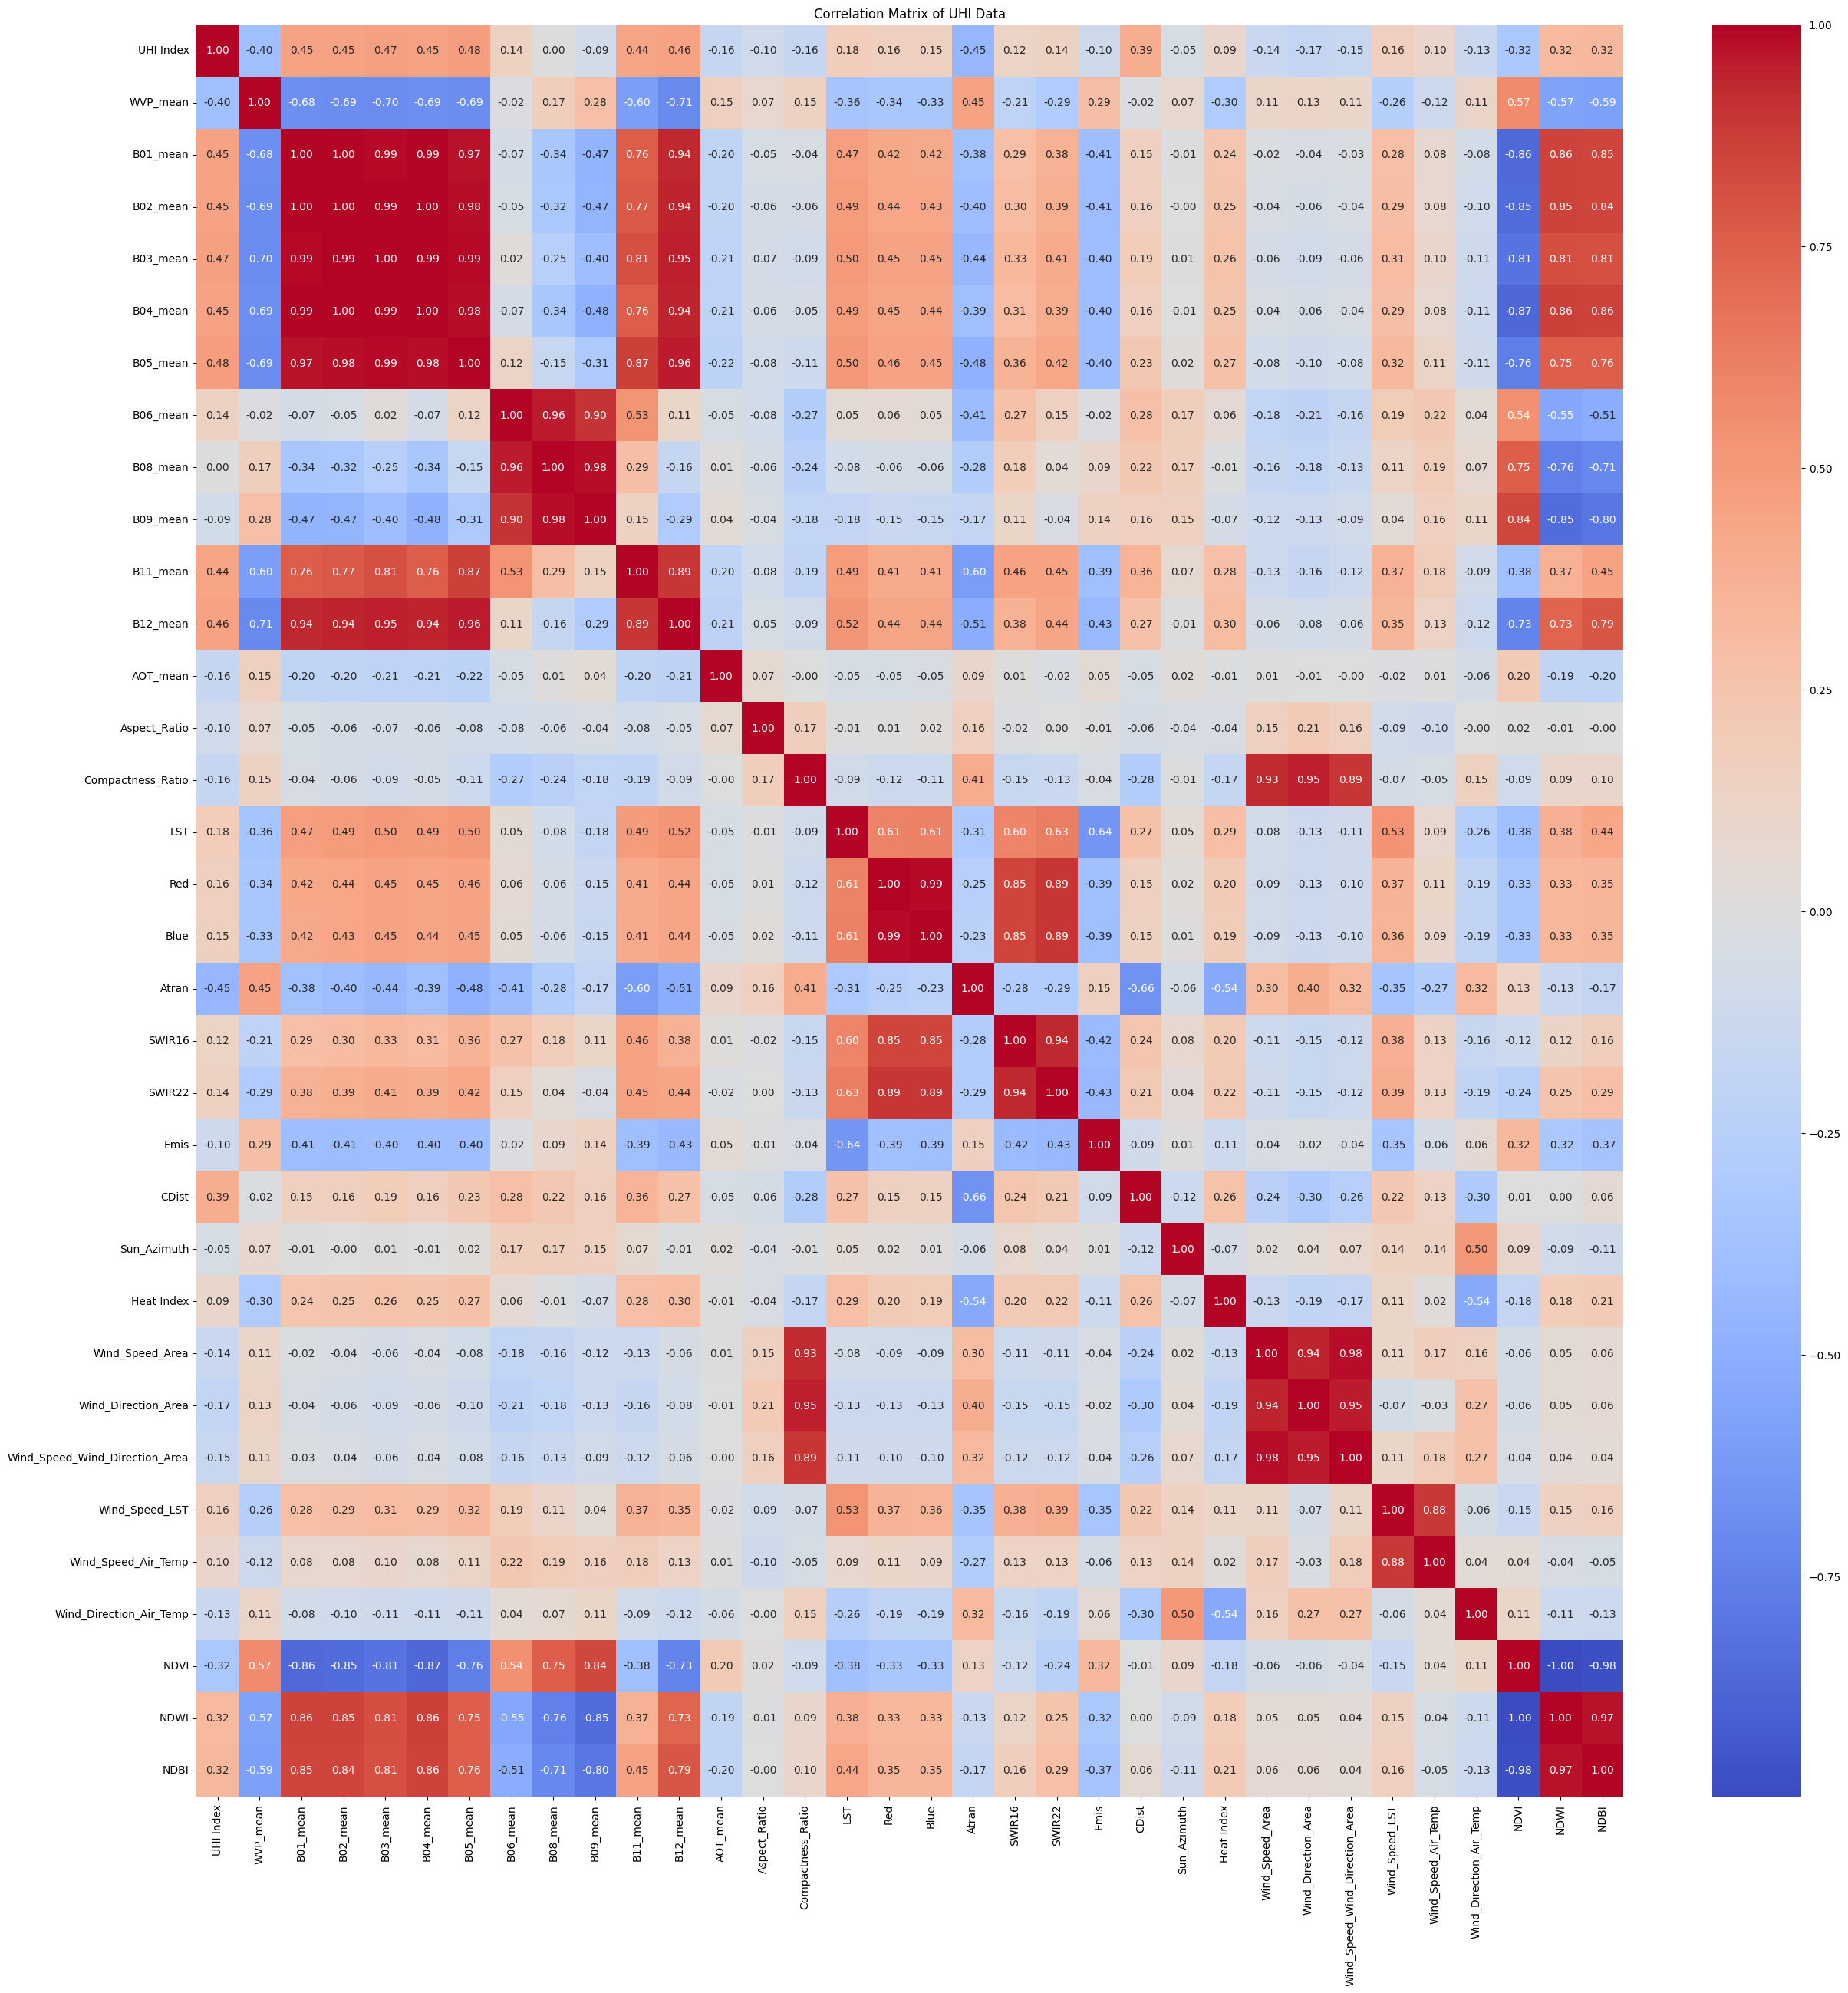

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove columns we don't want and keep as a DataFrame (not a NumPy array)
A = uhi_gdf.drop(columns=["Longitude", "Latitude", "geometry","datetime"])
# Example of other columns you could drop if needed:
# "Building_Height","Distance_to_Building","Solar_Radiation","Sun_Angle",
# "Solar_Impact","Shading_Index","Solar_Radiation_Adjusted","LST_Deviation",
# "LST_Diff","Shape_Factor","Wind_Resistance","Shading_Index_Solar_Flux",
# "Shading_Coverage","Thermal_Mass"

# Calculate the correlation matrix
correlation_matrix = A.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix of UHI Data")
plt.show()


In [ ]:
# Εμφάνιση των πρώτων γραμμών για επιβεβαίωση
print(uhi_gdf.head())
print(val_gdf.head())

   Longitude   Latitude            datetime  UHI Index  \
0 -73.959827  40.758792 2021-07-24 15:15:00   0.979081   
1 -73.959775  40.758795 2021-07-24 15:15:00   0.979081   
2 -73.959882  40.758797 2021-07-24 15:15:00   0.979081   
3 -73.959925  40.758808 2021-07-24 15:14:00   0.979081   
4 -73.959733  40.758810 2021-07-24 15:15:00   0.974754   

                     geometry  WVP_mean  B01_mean  B02_mean  B03_mean  \
0  POINT (-73.95983 40.75879)  0.173876  0.090856  0.101480  0.114862   
1   POINT (-73.95978 40.7588)  0.173891  0.090558  0.101251  0.114549   
2   POINT (-73.95988 40.7588)  0.173898  0.091200  0.101855  0.115300   
3  POINT (-73.95992 40.75881)  0.173941  0.091678  0.102394  0.115895   
4  POINT (-73.95973 40.75881)  0.173908  0.090448  0.101153  0.114409   

   B04_mean  ...  Heat Index  Wind_Speed_Area  Wind_Direction_Area  \
0  0.122191  ...   80.743321      9022.329225        448206.032474   
1  0.121736  ...   80.743321      9022.329225        448206.032474   
2 

In [ ]:
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    ExtraTreesRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Parameter grid for multiple regression models
# Each model has a sub-dictionary with 'model' and 'params' keys
param_grid = {
  #  "RandomForest": {
  #      "model": RandomForestRegressor(random_state=42),
  #      "params": {
  #          "n_estimators": [50, 100, 200],
  #          "max_depth": [None, 10, 20],
  #          "min_samples_split": [2, 5, 10]
  #      }
  #  },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 300, 600, 1000],       # Number of boosting stages
            "learning_rate": [0.01, 0.05, 0.1, 0.2],     # Step size shrinkage
            "max_depth": [3, 5, 10, 15],                 # Depth of individual trees
            "min_samples_split": [2, 5, 10],             # Minimum samples to split a node
            "min_samples_leaf": [1, 3, 5],               # Minimum samples per leaf
            "subsample": [0.7, 0.85, 1.0],               # Fraction of samples for each tree
            "max_features": ["auto", "sqrt", "log2"]     # Features considered for split
        }
    },
    #"HistGradientBoosting": {
    #    "model": HistGradientBoostingRegressor(random_state=42),
    #    "params": {
    #        "max_iter": [100, 200, 300],
    #        "learning_rate": [0.01, 0.1, 0.2],
    #        "max_depth": [3, 5, 10]
    #    }
    #},
    #"XGBoost": {
    #    "model": xgb.XGBRegressor(random_state=42),
    #    "params": {
    #        "n_estimators": [100, 200, 300],
    #        "learning_rate": [0.01, 0.1, 0.2],
    #        "max_depth": [3, 5, 10]
    #    }
    #},
    #"LightGBM": {
    #    "model": lgb.LGBMRegressor(random_state=42),
    #    "params": {
    #        "n_estimators": [100, 300, 500],
    #        "learning_rate": [0.05, 0.1, 0.2],
    #        "max_depth": [10, 15, 20],
    #        "num_leaves": [31, 50, 100],
    #        "min_data_in_leaf": [20, 50, 100],
    #        "feature_fraction": [0.8, 0.9, 1.0],
    #        "bagging_fraction": [0.8, 0.9, 1.0],
    #        "bagging_freq": [1, 5, 10]
    #    }
    #},
    #"CatBoost": {
    #    "model": CatBoostRegressor(random_state=42, verbose=0),
    #    "params": {
    #        "iterations": [100, 200, 300],
    #        "learning_rate": [0.01, 0.1, 0.2],
    #        "depth": [3, 6, 10]
    #    }
    #},
    #"ExtraTrees": {
    #    "model": ExtraTreesRegressor(random_state=42),
    #    "params": {
    #        "n_estimators": [50, 100, 200],
    #        "max_depth": [None, 10, 20],
    #        "min_samples_split": [10, 15, 20]
    #    }
    #},
    #"Lasso": {
    #    "model": Lasso(),
    #    "params": {
    #        "alpha": [0.001, 0.01, 0.1, 1, 10],
    #        "max_iter": [1000, 2000, 3000]
    #    }
    #},
    #"SVR": {
    #    "model": SVR(),
    #    "params": {
    #        "C": [0.1, 1, 10],
    #        "epsilon": [0.01, 0.1, 1],
    #        "kernel": ["linear", "rbf"]
    #    }
    #},
    #"Ridge": {
    #    "model": Ridge(),
    #    "params": {
    #        "alpha": [0.1, 1, 10],
    #        "solver": ["auto", "svd", "cholesky"]
    #    }
    #}
}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# --- Option 1: Drop datetime entirely ---
# drop_columns = ["Longitude", "Latitude", "UHI Index", "datetime"]

# --- Option 2: Extract numeric time features ---
uhi_gdf["year"] = uhi_gdf["datetime"].dt.year
uhi_gdf["month"] = uhi_gdf["datetime"].dt.month
uhi_gdf["day"] = uhi_gdf["datetime"].dt.day
uhi_gdf["hour"] = uhi_gdf["datetime"].dt.hour
uhi_gdf = uhi_gdf.drop(columns=["datetime"], errors="ignore")

# Drop non-feature columns
drop_columns = ["Longitude", "Latitude", "UHI Index","geometry","year","month","day","hour"]

# Keep only numeric features
X = uhi_gdf.drop(columns=drop_columns, errors="ignore")
X = X.select_dtypes(include=["number"])  # removes any non-numeric leftovers
y = uhi_gdf["UHI Index"].values



In [ ]:
 uhi_gdf

Longitude   Latitude  UHI Index                    geometry  WVP_mean  \
0     -73.959827  40.758792   0.979081  POINT (-73.95983 40.75879)  0.173876   
1     -73.959775  40.758795   0.979081   POINT (-73.95978 40.7588)  0.173891   
2     -73.959882  40.758797   0.979081   POINT (-73.95988 40.7588)  0.173898   
3     -73.959925  40.758808   0.979081  POINT (-73.95992 40.75881)  0.173941   
4     -73.959733  40.758810   0.974754  POINT (-73.95973 40.75881)  0.173908   
...          ...        ...        ...                         ...       ...   
11224 -73.932255  40.859448   1.025721  POINT (-73.93226 40.85945)  0.166414   
11225 -73.931920  40.859462   1.025721  POINT (-73.93192 40.85946)  0.164873   
11226 -73.932202  40.859482   1.025721   POINT (-73.9322 40.85948)  0.166377   
11227 -73.932132  40.859495   1.021394   POINT (-73.93213 40.8595)  0.165861   
11228 -73.932057  40.859497   1.021394   POINT (-73.93206 40.8595)  0.165424   

       B01_mean  B02_mean  B03_mean  B04_mean  B05_mean  ...  Wind_Speed_LST  \
0      0.090856  0.101480  0.114862  0.122191  0.136574  ...      121.182773   
1      0.090558  0.101251  0.114549  0.121736  0.135950  ...      121.182773   
2      0.091200  0.101855  0.115300  0.122748  0.137249  ...      121.182773   
3      0.091678  0.102394  0.115895  0.123485  0.138103  ...      121.182773   
4      0.090448  0.101153  0.114409  0.121563  0.135738  ...      121.182773   
...         ...       ...       ...       ...       ...  ...             ...   
11224  0.086305  0.093065  0.112558  0.105940  0.141481  ...      144.348481   
11225  0.093406  0.101236  0.120400  0.115491  0.149606  ...      144.348481   
11226  0.085871  0.092593  0.112081  0.105389  0.140965  ...      144.348481   
11227  0.088548  0.095654  0.114999  0.108947  0.143995  ...      144.348481   
11228  0.089990  0.097353  0.116661  0.110968  0.145673  ...      144.348481   

       Wind_Speed_Air_Temp  Wind_Direction_Air_Temp      NDVI      NDWI  \
0                  247.628                 12301.52  0.142910 -0.173064   
1                  247.628                 12301.52  0.141619 -0.171299   
2                  247.628                 12301.52  0.143187 -0.173696   
3                  247.628                 12301.52  0.142894 -0.173815   
4                  247.628                 12301.52  0.141550 -0.171133   
...                    ...                      ...       ...       ...   
11224              363.510                 13732.60  0.504627 -0.481700   
11225              363.510                 13732.60  0.465478 -0.449018   
11226              363.510                 13732.60  0.506734 -0.483500   
11227              363.510                 13732.60  0.492257 -0.471504   
11228              363.510                 13732.60  0.483485 -0.464087   

           NDBI  year  month  day  hour  
0     -0.025110  2021      7   24    15  
1     -0.025493  2021      7   24    15  
2     -0.024507  2021      7   24    15  
3     -0.023486  2021      7   24    15  
4     -0.025480  2021      7   24    15  
...         ...   ...    ...  ...   ...  
11224 -0.183128  2021      7   24    15  
11225 -0.163244  2021      7   24    15  
11226 -0.184088  2021      7   24    15  
11227 -0.176868  2021      7   24    15  
11228 -0.172383  2021      7   24    15  

[11229 rows x 41 columns]

In [ ]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=123
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training features shape:", X_train_scaled.shape)
print("Test features shape:", X_test_scaled.shape)
print("Training target shape:", y_train.shape)


Training features shape: (8983, 33)
Test features shape: (2246, 33)
Training target shape: (8983,)


In [ ]:
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.svm import SVR
#from sklearn.linear_model import Ridge
#from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.preprocessing import StandardScaler
#import numpy as np
#import pandas as pd
#
## 2. GridSearch for each model
#best_models = {}
#r2_adj_scores = {}
#
#n = X_test_scaled.shape[0]  # Number of samples in the test set
#p = X_test_scaled.shape[1]  # Number of features
#
#for name, config in param_grid.items():
#    print(f"🔍 Running GridSearch for {name}...")
#    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', verbose=2, n_jobs=-1)
#    grid.fit(X_train_scaled, y_train)
#    best_models[name] = grid.best_estimator_
#
#    # Evaluate on the test set
#    predictions = grid.best_estimator_.predict(X_test_scaled)
#    r2 = r2_score(y_test, predictions)
#    r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)  # Adjusted R² calculation
#    r2_adj_scores[name] = r2_adj
#
#    print(f"✅ Best parameters for {name}: {grid.best_params_}")
#    print(f"📈 Adjusted R² on the test set: {r2_adj:.2f}")
#
## 3. Select the best model based on Adjusted R²
#best_model_name = max(r2_adj_scores, key=r2_adj_scores.get)
#print(f"\n🏆 Best model: {best_model_name} with Adjusted R²: {r2_adj_scores[best_model_name]:.2f}")
#
## 4. Results for all models
#for name, r2_adj in r2_adj_scores.items():
#    print(f"{name}: Adjusted R² on the test set: {r2_adj:.2f}")
#

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb

# Create and train the model (Random Forest or Gradient Boosting)
# model = RandomForestRegressor(n_estimators=600, max_depth=10, random_state=42)
model = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=10,
    n_estimators=600,
    random_state=42
)

# Train the model
# Example: Assign more weight to larger y_train values
# weights = np.abs(y_train)
# model.fit(X_train_scaled, y_train, sample_weight=weights)

model.fit(X_train_scaled, y_train)

# Early stopping example: stops if R² does not improve for 50 iterations
# model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)],
#           early_stopping_rounds=50, verbose=True)


GradientBoostingRegressor(max_depth=10, n_estimators=600, random_state=42)

In-Sample R² Score: 0.99991
In-Sample Mean Squared Error (MSE): 0.0000000
Out-of-Sample R² Score: 0.96918
Out-of-Sample Mean Squared Error (MSE): 0.0000081

Correlation Matrix:
[[1.         0.98447151]
 [0.98447151 1.        ]]


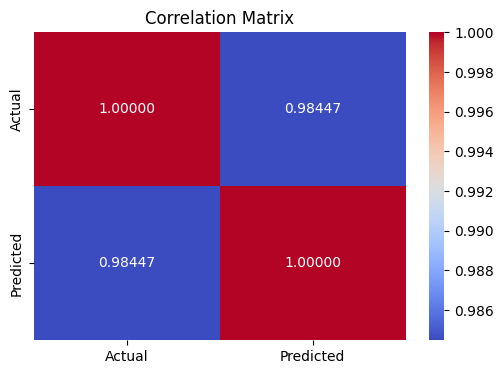

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions for the training set
insample_predictions = model.predict(X_train_scaled)

# Calculate R² score and MSE for the training set
r2_train = r2_score(y_train, insample_predictions)
mse_train = mean_squared_error(y_train, insample_predictions)
print(f"In-Sample R² Score: {r2_train:.5f}")
print(f"In-Sample Mean Squared Error (MSE): {mse_train:.7f}")

# Predictions for the test set
outsample_predictions = model.predict(X_test_scaled)

# Calculate R² score and MSE for the test set
r2_test = r2_score(y_test, outsample_predictions)
mse_test = mean_squared_error(y_test, outsample_predictions)
print(f"Out-of-Sample R² Score: {r2_test:.5f}")
print(f"Out-of-Sample Mean Squared Error (MSE): {mse_test:.7f}")

# Calculate Correlation Matrix for the test set
actual_vs_predicted = np.vstack((y_test, outsample_predictions)).T
correlation_matrix = np.corrcoef(actual_vs_predicted.T)
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualization of the Correlation Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.5f',
            xticklabels=['Actual', 'Predicted'], yticklabels=['Actual', 'Predicted'])
plt.title('Correlation Matrix')
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Predictions for the training set
insample_predictions = model.predict(X_train_scaled)

# Calculate R² score for the training set
r2_train = r2_score(y_train, insample_predictions)
print(f"In-Sample R² Score: {r2_train:.2f}")


In-Sample R² Score: 1.00


In [ ]:
# Predictions for the test set
outsample_predictions = model.predict(X_test_scaled)

# Calculate R² score for the test set
r2_test = r2_score(y_test, outsample_predictions)
print(f"Out-of-Sample R² Score: {r2_test:.2f}")


Out-of-Sample R² Score: 0.97


In [ ]:
# 1. Remove irrelevant columns for prediction
val_features = val_gdf.drop(columns=["Longitude", "Latitude", "UHI Index"])

# 2. Scale the validation features using the scaler fitted on training data
X_submission_scaled = scaler.transform(val_features)

# 3. Predict UHI Index using the trained model
val_gdf["UHI Index"] = model.predict(X_submission_scaled)

# Keep only Longitude, Latitude, and predicted UHI Index for submission
final_val_gdf = val_gdf[["Longitude", "Latitude", "UHI Index"]]

# Save the final DataFrame to CSV without index or header
final_val_gdf.to_csv("Submission_template_UHI2025-v222.csv", index=False)

# Display the shape of the final DataFrame
#print(final_val_gdf.shape)
